We are going to implement a code for Linear Quadratic Control problem 

Loss function = $\mathbb{E}\bigg[\int_0^T(aX_t^2+bX_t+Au_t^2+Bu_t)dt+\alpha X_T^2+\beta X_T\bigg]$


State Process $dX_{t}=(cX_t+du_t)dt+\sigma dB_t$

The HJB equation is given by

$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx+\inf_u\Big[Au^2+\Big(B+d\partial_xV(t,x)\Big)u\Big]$

$V(T,x)=\alpha x^2+\beta x$.

The optimal solution solution obtained as
$u^*=-\frac{B+d\partial_xV(t,x)}{2A}$
depends on the value function $V(t,x)$, which is the solution of the following PDE
$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx-\frac{\big(B+d\partial_xV(t,x)\big)^2}{4A}$

$V(T,x)=\alpha x^2+\beta x$.

In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float64)
import random
import math
import pandas as pd
from scipy.optimize import fsolve
# from scipy.integrate import solve_ivp # type: ignore
import scipy.integrate as integrate

import json

from IPython.display import display, Math, Markdown
import seaborn as sns
sns.set(font_scale = 2)

import pandas as pd
import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_9'

# Three steps

# Different choices for sample numbers

For $2$-fold PGM and $N=5$, one can choose $R\approx2$, $I_2=\frac{3}{5}$, $I_3=\frac{1}{6}$, $g_3=\frac{1}{2}$, $0<\dfrac{g_1}{25}<\frac{g_2}{5}<\frac{1}{2}$. Hence,

$\dfrac{c_{1}J_{1}}{cJ}=g_1,~~\dfrac{c_{2}I_{2}J_{2}}{cJ}=g_1-\dfrac{g_2}{5}~~\text{and}~\dfrac{c_{3}I_{3}J_{3}}{cJ}=\frac{1}{2}-\dfrac{g_2}{5}, ~\text{ with } 0<\frac{g_1}{5}<{g_2}<\frac{5}{2}$.

$J=100$, Time =$160$ seconds

| $g_1$ | $g_2$ | $J_1$ | $J_2$ | $J_3$ | Time | 
| --- | --- | --- | --- | --- | --- |
| $1$ | $\frac{59}{24}$ | $100$ | $50$ | $5$ | $10 + 77 + 7 = 94$ | 

In [2]:
(1/2-7/25)*6, 59/24 

(1.3199999999999998, 2.4583333333333335)

# Parameters

In [3]:
# lqsc_params = {
#     'T':1,
#     'a':0.1,
#     'b':0.1,
#     'c':-1,
#     'd':1,
#     'A':1,
#     'B':1,
#     'sigma':0.5,
#     'alpha':1,
#     'beta':1,
#     'gamma':0.0,
#     }
lqsc_params = {
    'T':1.25,
    'a':100,
    'b':0.1,
    'c':1.5,
    'd':-1.,
    'A':0.1,
    'B':0.1,
    'sigma':0.5,
    'alpha':0.1,
    'beta':0.1,
    'gamma':0.0
    }

# Function class

In [4]:
class func(object):
    def __init__(self, lqsc_params):
        self.alpha = lqsc_params['alpha']
        self.beta = lqsc_params['beta']
        self.gamma = lqsc_params['gamma']
        self.A = lqsc_params['A']
        self.B = lqsc_params['B']
        self.a = lqsc_params['a']
        self.b = lqsc_params['b']
        self.c = lqsc_params['c']
        self.d = lqsc_params['d']
        self.T = lqsc_params['T']
        self.sigma = lqsc_params['sigma']

    
class term(func):
    def __init__(self, lqsc_params): 
        super(term, self).__init__(lqsc_params)
        self.fnc = lambda tx: self.alpha*torch.pow(tx[:,1],2)+self.beta*tx[:,1]+self.gamma
    def __call__(self,tx):
            return self.fnc(tx)
        
class solution(func):
    def __init__(self, lqsc_params):
        super(solution, self).__init__(lqsc_params)
        q0=self.a
        q1=2*self.c
        q2 = -self.d**2/self.A
        lb1=0.5*(q1+np.sqrt(q1**2-4*q0*q2))
        lb2 = -lb1+q1
        C1 = -(lb1+q2*self.alpha)/(lb2+q2*self.alpha)
        C2 = self.beta*(1+C1)-self.b*(1/(lb1-self.c)+C1/(lb2-self.c))+self.B/self.d*(lb1/(lb1-self.c)+C1*lb2/(lb2-self.c))
        self.f_func = lambda t: -1/q2*(lb1*np.exp(lb1*(self.T-t))+C1*lb2*np.exp(lb2*(self.T-t)))/(np.exp(lb1*(self.T-t))+C1*np.exp(lb2*(self.T-t)))
        self.h_func = lambda t: (self.b*((1/(lb1-self.c))*np.exp(lb1*(self.T-t))+C1*(1/(lb2-self.c))*np.exp(lb2*(self.T-t)))-self.B/self.d*((lb1/(lb1-self.c))*np.exp(lb1*(self.T-t))+C1*(lb2/(lb2-self.c))*np.exp(lb2*(self.T-t)))+C2*np.exp(self.c*(self.T-t)))/(np.exp(lb1*(self.T-t))+C1*np.exp(lb2*(self.T-t)))
        self.integrand = lambda t: self.sigma**2*self.f_func(self.T-t) -(self.B+self.d*self.h_func(self.T-t))**2/(4*self.A)
        self.k_func = lambda t: integrate.quad(lambda x: self.integrand(x), 0, self.T-t)[0]        
    def __call__(self,tx):
            return np.array([self.f_func(tx[i,0])*np.power(tx[i,1],2)+self.h_func(tx[i,0])*tx[i,1]+self.k_func(tx[i,0]) for i in range(tx.shape[0])])
    def optimal_policy(self,tx):
            return np.array([2*self.f_func(tx[i,0])*tx[i,1]+self.h_func(tx[i,0]) for i in range(tx.shape[0])])      

In [5]:
t1 = term(lqsc_params)
input=torch.tensor([[0,1],[1,.2]])
t1(input)#,lqsc.loss_func_ter(input)

tensor([0.2000, 0.0240])

# Closed-from solution for LQSC

In [6]:
solution = solution(lqsc_params)

We assume that the value function is quadratic in $x$,

$V(t,x)=f(t)x^2+h(t)x+k(t)$. 

By substituting $V$ in the HJB PDE we get the following system of Riccati ODE.

$0=f'+a+2cf-\frac{d^2}{A}f^2;  f(T)=\alpha$

$0=h'+b-\frac{(B+dh)d}{A}f;  h(T)=\beta$

$0=k'+\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(T)=\gamma$

By solving this system of first order ODE we can get $f,h,t$ in closed form and we obtain the optimal solution as

$u^*=-\frac{B+d(2xf(t)+h(t))}{2A}$

First let's write all equations forward and then change $t$ to $T-t$ at the end.

$f'=a+2cf-\frac{d^2}{A}f^2;  f(0)=\alpha$

$h'=b-\frac{(B+dh)d}{A}f;  h(0)=\beta$

$k'=\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(0)=\gamma$

$f$ satisfies a Riccati ODE: $f(t)=-\dfrac{1}{q_2}\dfrac{\lambda_1 e^{\lambda_1 t}+C\lambda_2 e^{\lambda_2 t}}{ e^{\lambda_1 t}+C e^{\lambda_2 t}}$ with

$C=-\dfrac{\lambda_1+q_2\alpha}{\lambda_2+q_2\alpha}$, $q_2=-\dfrac{d^2}{A}$, $q_1=2c$, $q_0=a$, $\lambda_1=\dfrac{q_1+\sqrt{q_1^2-2q_0q_2}}{2}$, and $\lambda_2=\dfrac{q_1-\sqrt{q_1^2-2q_0q_2}}{2}$


$h'=b-\frac{Bd}{A}f+(c-\frac{d^2}{A}f)h = b-\frac{Bd}{A}f+(c+q_2f)h ;  h(0)=\beta$

$h'-(c+q_2f)h= b-\frac{Bd}{A}f$


$\left( e^{-(ct+q_2\int fdt)}h\right)'= e^{-ct-q_2\int fdt}(b-\frac{Bd}{A}f)$


In the process of finding $f$, we note that $f = -\dfrac{U'(t)}{q_2U(t)}$, where $U(t)=e^{\lambda_1 t}+Ce^{\lambda_2 t}$. Thus,

$-q_2\int f dt = \ln U(t)$ and $e^{-q_2\int fdt}=U(t)$.


$e^{-ct}U(t) h(t) = \int e^{-cs}U(s)(b-\frac{Bd}{A}f(s))ds = \int e^{-ct}U(s)(b+\frac{Bd}{A}\dfrac{U'(s)}{q_2U(s)})ds= \int e^{-cs}(U(s)b-\frac{B}{d}{U'(s)})ds$


$h(t) =  \dfrac{e^{ct}}{U(t)}\int e^{-cs}(U(s)b+\frac{B}{d}{U'(s)})ds= \dfrac{b(\frac{1}{\lambda_1-c}e^{\lambda_1 t}+C\frac{1}{\lambda_2-c}e^{\lambda_2t} )-\frac{B}{d}(\frac{\lambda_1}{\lambda_1-c}e^{\lambda_1t}+C\frac{\lambda_2}{\lambda_2-c}e^{\lambda_2t})+C_2 e^{ct}}{U(t)}$, where $C_2$ is such that $h(0)=\beta$:

$C_2=\beta(1+C)-b(\frac{1}{(\lambda_1-c)}+\frac{C}{(\lambda_2-c)})+\frac{B}{d}(\frac{\lambda_1}{(\lambda_1-c)}+C\frac{\lambda_2}{(\lambda_2-c)})$

For $k'=\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(0)=0$:

$\sigma^2\int f dt = -\dfrac{\sigma^2}{q_2}\ln U(t) +C_3$


To find $\int (B+dh)^2 dt$ note that $B+dh=b\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}$

$\int (B+dh)^2 dt=b^2\displaystyle\int \left(\dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}+C_2}{U(t)}\right)^2dt=b^2\displaystyle\int \dfrac{(\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t})^2}{U^2(t)}dt+2b^2C_2\displaystyle\int \dfrac{\frac{1}{\lambda_1}e^{\lambda_1 t}+C\frac{1}{\lambda_2}e^{\lambda_2 t}}{U^2(t)}dt+C^2_2\displaystyle\int \dfrac{1}{U^2(t)}dt$ 

The above three integrals are evaluated here:

https://www.wolframalpha.com/input?i=%5Cint+%28n+%2B+c+me%5E%7Bbt%7D%29%2F%28%281%2B+c+e%5E%7Bbt%7D%29%5E2%29dt

https://www.wolframalpha.com/input?i=%5Cint+%28%28n+%2B+c+me%5E%7Bbt%7D%29%5E2%29%2F%28%281%2B+c+e%5E%7Bbt%7D%29%5E2%29dt

https://www.wolframalpha.com/input?i=%5Cint+1%2F%28%28e%5E%7Bat%7D%2B+c+e%5E%7Bbt%7D%29%5E2%29dt







# PGM

## PGM parameters

In [7]:
# model_params = {
#     'num_samples':100,
#     'num_time_steps':20,
#     'num_neurons_p':50,
#     'num_neurons_v':10,
#     'lr' : 8e-3,
#     'num_epochs' : 3000,
#     'xmin' : 0.,
#     'xmax' : 1.,
#     'intervals' : None # a list of numbers between 0 to num_intervals-1
#     }
# model_params = {
#     'num_samples':100,
#     'num_time_steps':10,
#     'num_neurons_p':50,
#     'num_neurons_v':10,
#     'lr' : 8e-3,
#     'num_epochs' : 3000,
#     'xmin' : -1.,
#     'xmax' : 1.,
#     'intervals' : None # a list of numbers between 0 to num_intervals-1
#     }
model_params = {
    'num_samples':100,
    'num_time_steps':5,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 8e-3,
    'num_epochs' : 3000,
    'xmin' : -10.,
    'xmax' : 10.,
    'intervals' : None # a list of numbers between 0 to num_intervals-1
    }

## PGM class

In [8]:
class pgm(object):
    def __init__(self, model_params, lqsc_params, fnc, **kwargs):
        self.value_eval = kwargs.get('value_eval', True)
        self.num_samples = model_params['num_samples']
        self.num_time_steps = model_params['num_time_steps']
        self.num_neurons_p = model_params['num_neurons_p']
        self.num_neurons_v = model_params['num_neurons_v']
        self.lr = model_params['lr']
        self.num_epochs = model_params['num_epochs']
        self.x0 = model_params['xmin']
        self.x1 = model_params['xmax']
        self.Num_steps = self.num_time_steps
        self.T = lqsc_params['T']
        self.delta = torch.tensor(self.T/self.num_time_steps)
        self.a=lqsc_params['a']
        self.b=lqsc_params['b']
        self.c=lqsc_params['c']
        self.d=lqsc_params['d']
        self.A=lqsc_params['A']
        self.B=lqsc_params['B']
        self.sigma=lqsc_params['sigma']
        self.alpha=lqsc_params['alpha']
        self.beta=lqsc_params['beta']
        self.gamma=lqsc_params['gamma']
        self.fnc = fnc#lambda tx: self.alpha*torch.pow(tx[:,1],2)+self.beta*tx[:,1]+self.gamma
        self.proper_int = lambda t: int((self.T-t)/self.delta)+1 if (self.T-t)/self.delta - int((self.T-t)/self.delta) > self.delta/2 else int((self.T-t)/self.delta)


        self.model= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p,1)
        )
        self.value= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v,1)
        )
        
        
    def gen_data(self):
        self.t=torch.zeros([self.num_samples,1])
        self.z= torch.normal(0, 1, size=(self.num_samples,self.num_time_steps+1))
        self.x_train=torch.FloatTensor(self.num_samples,1).uniform_(self.x0,self.x1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        self.data=torch.cat((self.t,self.x_train),dim=1)
    
    def update(self,x3,psi,i):
        t=(x3[:,0]+self.delta)
        x=x3[:,1]+(self.c*x3[:,1]+self.d*psi)*self.delta+self.sigma*torch.sqrt(self.delta)*self.z[:,i]
        up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
        return up

    def loss_func(self,x2,psi):
        loss=self.a*torch.pow(x2[:,1],2)+self.b*x2[:,1]+self.A*torch.pow(psi,2)+self.B*psi
        return loss

    def loss_func_ter(self,x4):
        # loss=self.alpha*torch.pow(x4[:,1],2)+self.beta*x4[:,1]
        return self.fnc(x4)#loss

    def unit(self,x1,i,policy, **kwargs):
        x2 = kwargs.get('disc_policy', x1)
        psi=policy(x2).squeeze(1)
        loss=self.loss_func(x1,psi)
        upd=self.update(x1,psi,i)
        #print('unit print=',psi.shape,los.shape,upd.shape)
        return psi,loss,upd

    def loss_func_total(self,epoch):
        u = self.data
        path = torch.zeros(self.num_samples,self.num_time_steps+1,2)
        path_loss=torch.zeros(self.num_samples,self.num_time_steps+1)
        psi=torch.zeros(self.num_samples,self.num_time_steps)
        if (epoch==self.num_epochs-1):
            self.state_var=u.clone().detach()
            path[:,0,:] = u.clone().detach()
        for i in range(self.num_time_steps):
            psi_run,loss_run,u_run=self.unit(u,i,self.model)
            #print('los func=',psi_run.shape,loss_run.shape)
            path_loss[:,i]=loss_run*self.delta
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==self.num_epochs-1):
                self.state_var = torch.concat((self.state_var,u.clone().detach()), axis=0)      
                path[:,i+1,:] =   u.clone().detach()    
        path_loss[:,-1]=self.loss_func_ter(u)
        if (epoch==self.num_epochs-1):
            a = torch.flip(path_loss, dims = (1,))
            b = torch.cumsum(a, dim=1)
            c = torch.flip(b, dims = (1,))
            d = torch.transpose(c,0,1)
            self.path_cost = d.reshape((self.num_time_steps+1)*self.num_samples,1).clone().detach()
            p = torch.transpose(path,0,1)
            self.path = p.reshape((self.num_time_steps+1)*self.num_samples,2).clone().detach()
        loss_=torch.sum(path_loss,dim=1)
        return loss_
    
    def train_it(self,**kwargs):
        M = kwargs.get('num_epochs', self.num_epochs)
        self.gen_data()
        start=time.time()
        cost_ar=[]
        optimizer = optim.Adam(self.model.parameters(), self.lr)
        E_ = -1e9
        E = 1e9
        m = 0
        while (np.abs((E-E_)/E_)>1e-6) and ( m <= M):
            optimizer.zero_grad()
            cost = self.loss_func_total(m)
            loss = torch.mean(cost)
            loss.backward()
            optimizer.step()
            cost_ar.append(loss)
            E_ = E
            E = loss.clone().detach().numpy().item()
            m += 1
            if (m % 1500==0):
                print("At epoch {} the mean cost is {}.".format(m,loss.detach()))
        #Run it one last time after training to save the path and cost
        optimizer.zero_grad()
        cost = self.loss_func_total(self.num_epochs-1)
        loss = torch.mean(cost)
        loss.backward()
        optimizer.step()
        cost_ar.append(loss)
        E_ = E
        E = loss.clone().detach().numpy().item()
            
        end=time.time()
        total_time=end-start
        print('Training time=',total_time)
        print("Last training epoch was {:d}".format(m+1))
        if self.value_eval:
            self.train_val_fnc()
    
    def policy(self,tx):
        return self.model(tx)
    
    def train_val_fnc(self,**kwargs):
        M = kwargs.get('num_epochs', self.num_epochs)
        K = kwargs.get('num_samples', self.num_samples)
        permuted_range = np.random.permutation((self.num_time_steps+1)*K)
        num_batches = int((K-1)/50) + 1
        epoch_cut = int(M/num_batches)
        tx = self.path[permuted_range,:]
        val = self.path_cost[permuted_range,:]
        optimizer_v = optim.Adam(self.value.parameters(), self.lr)
        start=time.time()
        E_ = -1e9
        E = 1e9
        m = 0
        i = -1
        while (np.abs((E-E_)/E_)>1e-6) and ( m <= M):
            i = int(m/epoch_cut)
        # for _ in range(M):
            r = range(i*50*(self.num_time_steps+1),min((i+1)*50*(self.num_time_steps+1),(self.num_time_steps+1)*K))
            loss_v = torch.nn.MSELoss()(self.value(tx[r,:]),val[r,:])
            optimizer_v.zero_grad()
            loss_v.backward()
            optimizer_v.step()
            E_ = E
            E = loss_v.clone().detach().numpy().item()
            m += 1
        end=time.time()
        total_time=end-start
        print('value function training time=',total_time)
        print("Last training epoch for the value function  was {:d}".format(m))
        
    def cost_eval(self,policy,num_samples,x0, **kwargs):
        M = kwargs.get('policy_update_lag', 1)
        if  self.num_time_steps%M!=0:
            raise ValueError(r"The number of time steps {:d} in this PGM instance must be divisible by the number of time steps {:d} in the input of disc_cost_eval(self,policy,num_samples,num_time_steps,x0).".format(self.num_time_steps,M))
        else:
            N = self.num_time_steps+1
            val=torch.zeros([num_samples])
            t=torch.zeros([num_samples,1])
            self.z= torch.normal(0, 1, size=(num_samples,N))
            x = x0*torch.ones([num_samples,1])
            full_path = torch.zeros(num_samples,N,2)
            full_path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
            for i in range(N-1):
                last_coarse_point = full_path[:,int(i/M),:]
                _,loss_run,u_run=self.unit(full_path[:,i,:],i,policy,disc_policy = last_coarse_point)
                full_path[:,i+1,:] = u_run.clone().detach() 
                val += (loss_run*self.delta).clone().detach()
            val += self.loss_func_ter(u_run).clone().detach()
            return torch.mean(val)     
    
    # We need the policy to only be evaluated at discrete points and stays unchanged until the next point.
    # def alt_value(self,num_samples,t,x):
    #     M = x.shape[0]
    #     x0 = x.repeat(num_samples).unsqueeze(-1)
    #     t0 = t.repeat(num_samples*M).unsqueeze(-1)
    #     N = self.proper_int(t) 
    #     full_path = torch.zeros(num_samples*M,N+1,2)
    #     # full_path_loss=torch.zeros(M,num_samples,N)
    #     self.z= torch.normal(0, 1, size=(M*num_samples,N))
    #     val=torch.zeros(num_samples*M)
    #     full_path[:,0,:] = torch.cat((t0,x0),dim=1).clone().detach()
    #     for i in range(N):
    #         _,loss_run,u_run=self.unit(full_path[:,i,:],i,self.policy)
    #         full_path[:,i+1,:] = u_run.clone().detach() 
    #         val += (loss_run*self.delta).clone().detach()
    #     # print(N,t)
    #     val += self.loss_func_ter(u_run).clone().detach()
    #     w = torch.reshape(val,[num_samples,M])
    #     return torch.mean(w,axis=0)
    
    def __call__(self,tx):
        return self.value(tx).squeeze(-1)

     


## Instance creation

In [9]:
lqsc = pgm(model_params,lqsc_params, t1)

## Training

In [10]:
lqsc.train_it()

Training time= 1.3007171154022217
Last training epoch was 285
value function training time= 1.5333449840545654
Last training epoch for the value function  was 3001


In [11]:
K1 = 20
L = 10
X1 = torch.linspace(-2.,2.,K1)
T = torch.zeros([K1,1])
tx1 = torch.concat((T,X1.unsqueeze(-1)),dim=1)
dfv_co = pd.DataFrame(np.zeros([K1*L,2]),columns=[1,'closed']); 
for i,_ in dfv_co.iterrows(): 
    for c in dfv_co.columns:
        if c != 'closed':
            dfv_co.loc[i,c] = lqsc.cost_eval(lqsc.policy,1,X1[i%K1],policy_update_lag=c).clone().detach().numpy()
dfv_co['closed'] = list(solution(tx1))*L
dfv_co['index'] = [str(np.round(x,3)) for x in X1.clone().detach().numpy()]*L
dfv_co.set_index('index',inplace=True,drop=True)
dfv_co


,1,closed
index,,
-2.0,105.606122,14.065820
-1.789,89.414237,11.443217
-1.579,64.753343,9.114538
-1.368,54.068870,7.079783
-1.158,40.408680,5.338953
...,...,...
1.158,43.909979,5.588819
1.368,50.226091,7.375080
1.579,68.400815,9.455265


/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_37069/2703621577.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_37069/2703621577.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right");


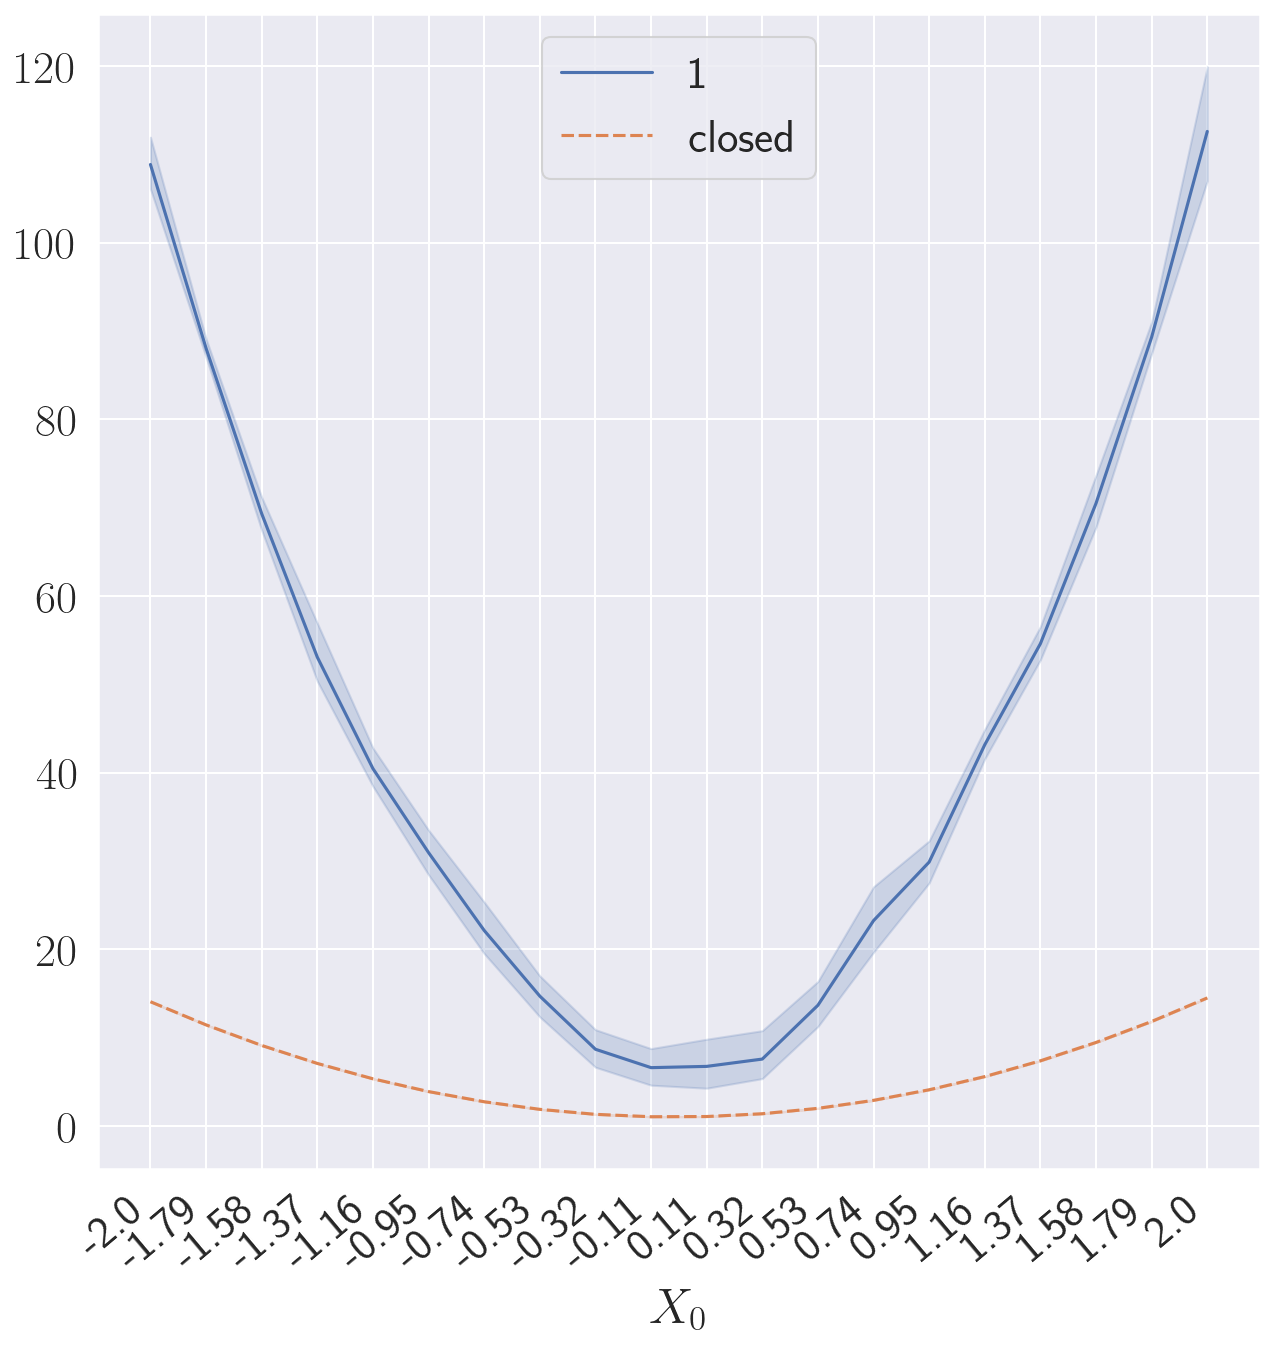

In [12]:
fig = plt.figure(figsize=(10,10),dpi=150);
g = sns.lineplot(data=dfv_co);
g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
g.set_xlabel(r"$X_0$");
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right");



In [13]:
K = 10
L = 10
X = torch.linspace(-10.,10.,K)
T = torch.zeros([K,1])
tx = torch.concat((T,X.unsqueeze(-1)),dim=1)
df_co = pd.DataFrame(np.zeros([K*L,2]),columns=[1,'closed']); 
for i,_ in df_co.iterrows(): 
    for c in df_co.columns:
        if c != 'closed':
            df_co.loc[i,c] = lqsc.cost_eval(lqsc.policy,1,X[i%K],policy_update_lag=c).clone().detach().numpy()
df_co['closed'] = list(solution(tx))*L
df_co['index'] = [str(np.round(x,3)) for x in X.clone().detach().numpy()]*L
df_co.set_index('index',inplace=True,drop=True)
df_co


,1,closed
index,,
-10.0,2594.476336,331.522635
-7.778,1567.026662,200.766526
-5.556,797.724527,102.759386
-3.333,288.882052,37.501217
-1.111,36.622893,4.992017
...,...,...
1.111,51.414109,5.231788
3.333,301.668596,38.220529
5.556,809.567047,103.958240


In [14]:
df_box_co = ((df_co[1]-df_co['closed'])/df_co['closed']).reset_index()
df_box_co.columns = ['x', 'rel_error']
df_box_co['Method'] = 'coarse'

/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_37069/3061354558.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(list(np.round(X.clone().detach().numpy(),2)));
/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_37069/3061354558.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="center");


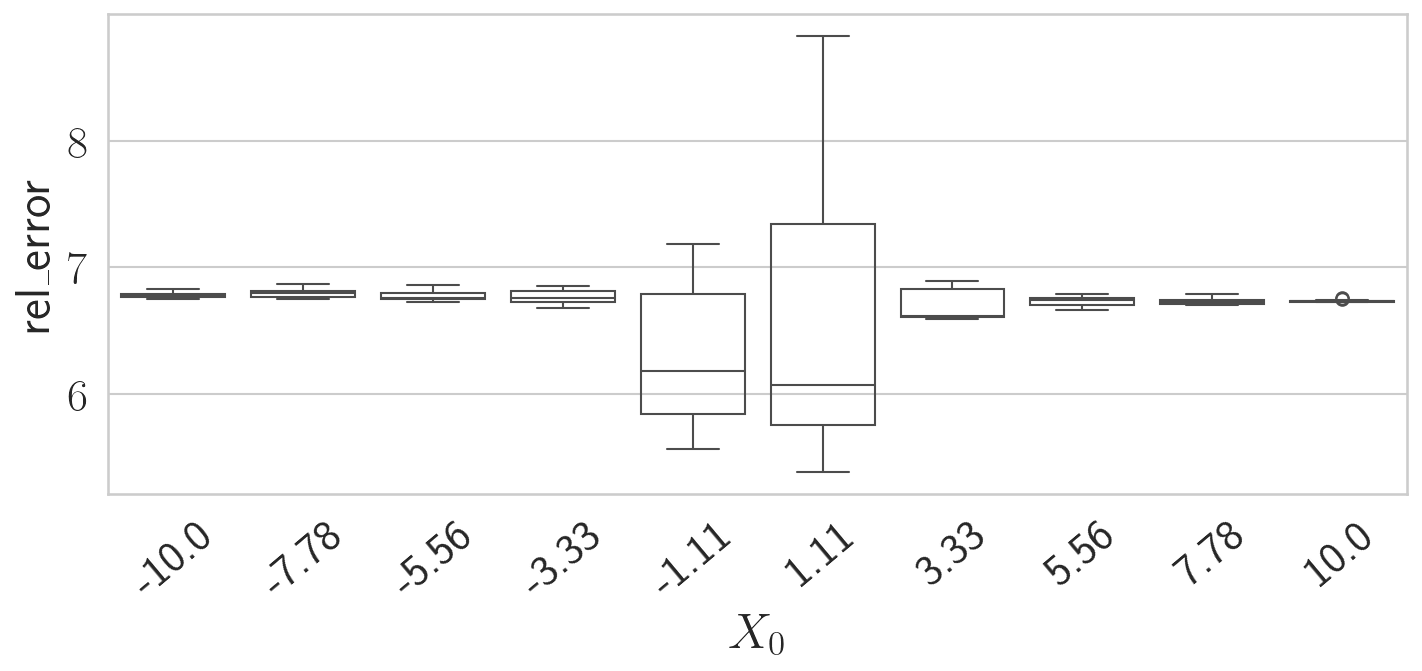

In [15]:
fig = plt.figure(figsize=(10,5),dpi=150);
sns.set_style("whitegrid");
g = sns.boxplot(data=df_box_co, y = 'rel_error', x = 'x', boxprops=dict(facecolor='none'));
g.set_xticklabels(list(np.round(X.clone().detach().numpy(),2)));
g.set_xlabel(r"$X_0$");
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="center");
plt.tight_layout();


In [16]:
lqsc.train_val_fnc(num_epochs=12000)

value function training time= 2.5944769382476807
Last training epoch for the value function  was 4977


Relative $L^1$ error $= 372.96\%$

Relative $L^2$ error $= 307.44\%$

Relative $L^\infty$ error $= 182.77\%$

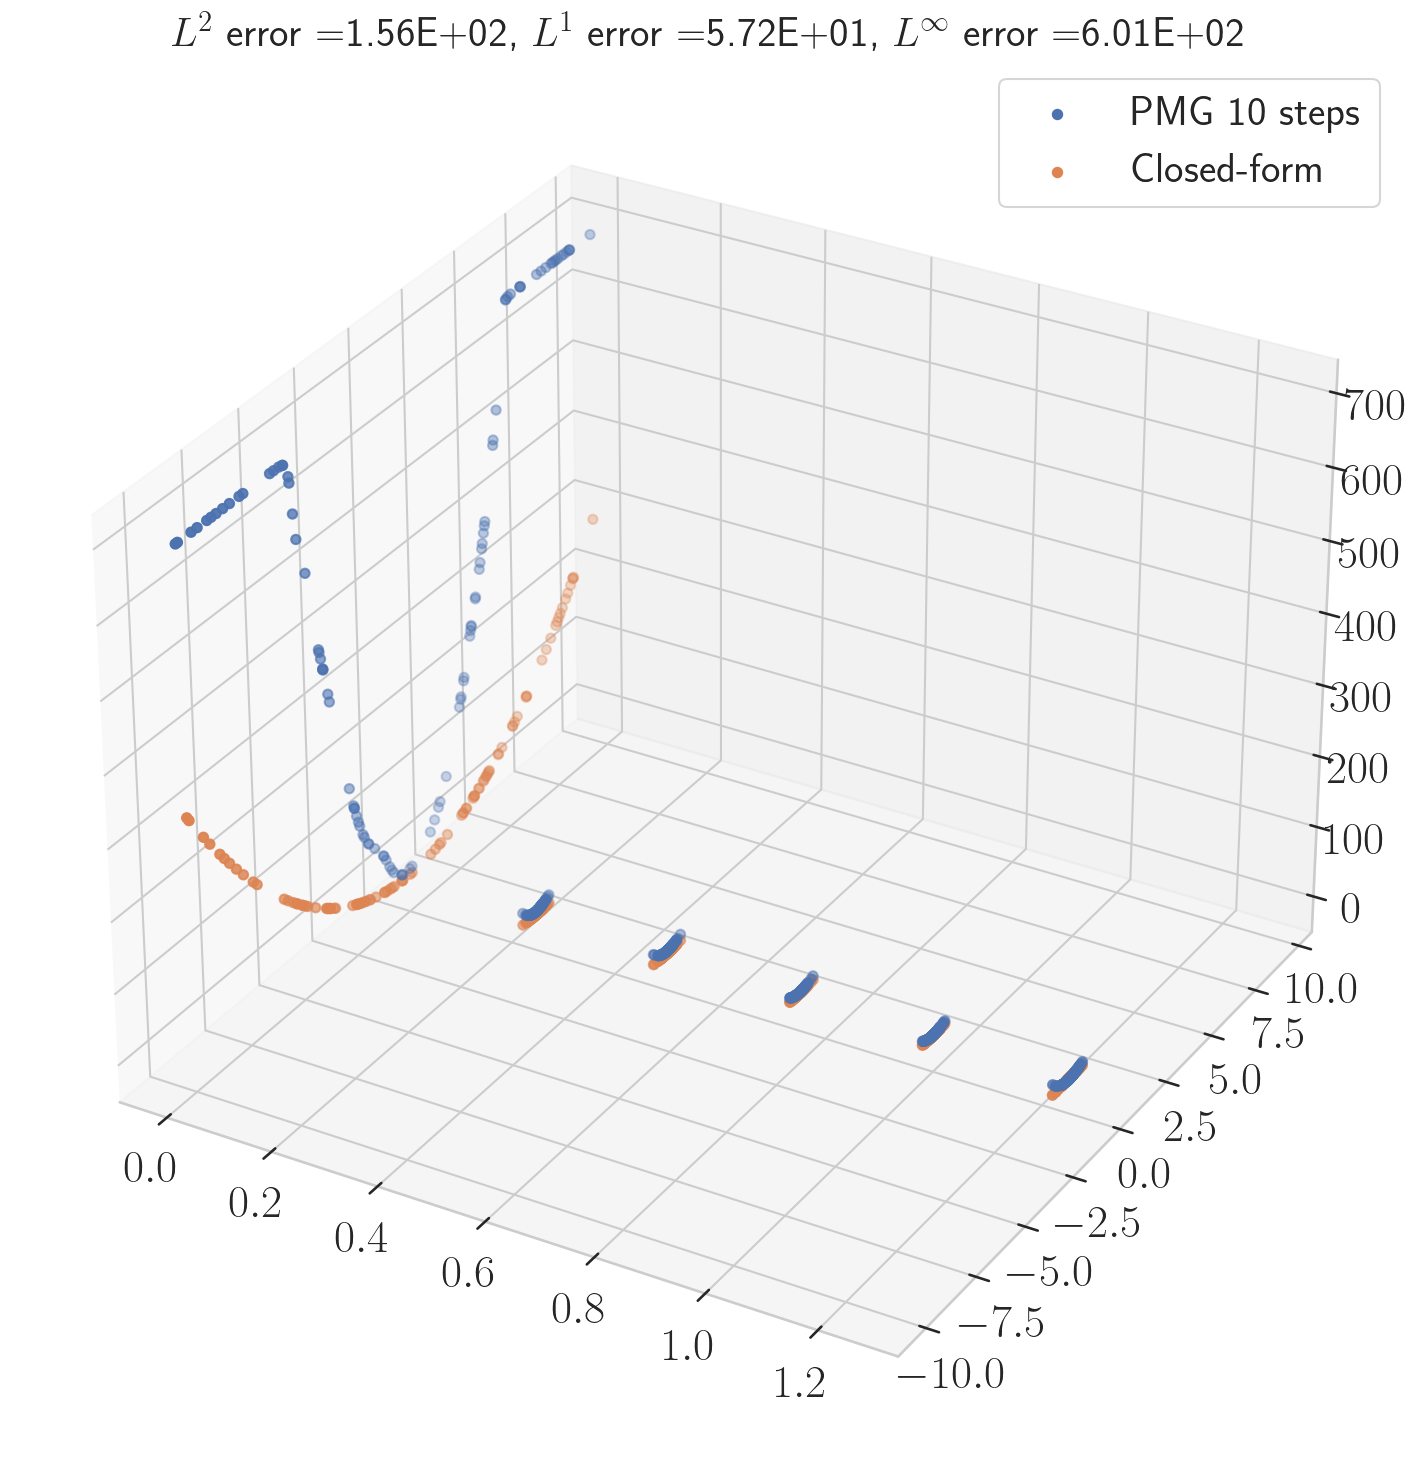

In [17]:
xyz = torch.concat((lqsc.path,lqsc(lqsc.path).unsqueeze(-1)),dim=1).clone().detach().numpy()
v = lqsc.value(lqsc.path).unsqueeze(-1).clone().detach().numpy()
fig = plt.figure(figsize=(12, 12), dpi=150)
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],label='PMG 10 steps')
ax.scatter(xyz[:,0], xyz[:,1], solution(xyz[:,0:2]),label='Closed-form')
# ax.scatter(xyz[:,0], xyz[:,1], v,label='DNN value function')

ax.set_title(r"$L^2$ error ={:.2E}, $L^1$ error ={:.2E},  $L^\infty$ error ={:.2E}".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2))),
                                                                                           np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
                                                                                           np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))
                                                                                           ), fontsize=20)
# ax.view_init(elev=30, azim=45, roll=0)
ax.legend(prop=font);
display(Markdown(r"Relative $L^1$ error $= {:.2f}\%$".format(np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.mean(np.abs(solution(xyz[:,0:2])))*100)))
display(Markdown(r"Relative $L^2$ error $= {:.2f}\%$".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2)))/np.sqrt(np.mean(np.power(solution(xyz[:,0:2]),2)))*100)))
display(Markdown(r"Relative $L^\infty$ error $= {:.2f}\%$".format(np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.max(np.abs(solution(xyz[:,0:2])))*100)))
plt.savefig('lqsc_3d.png', dpi=150)

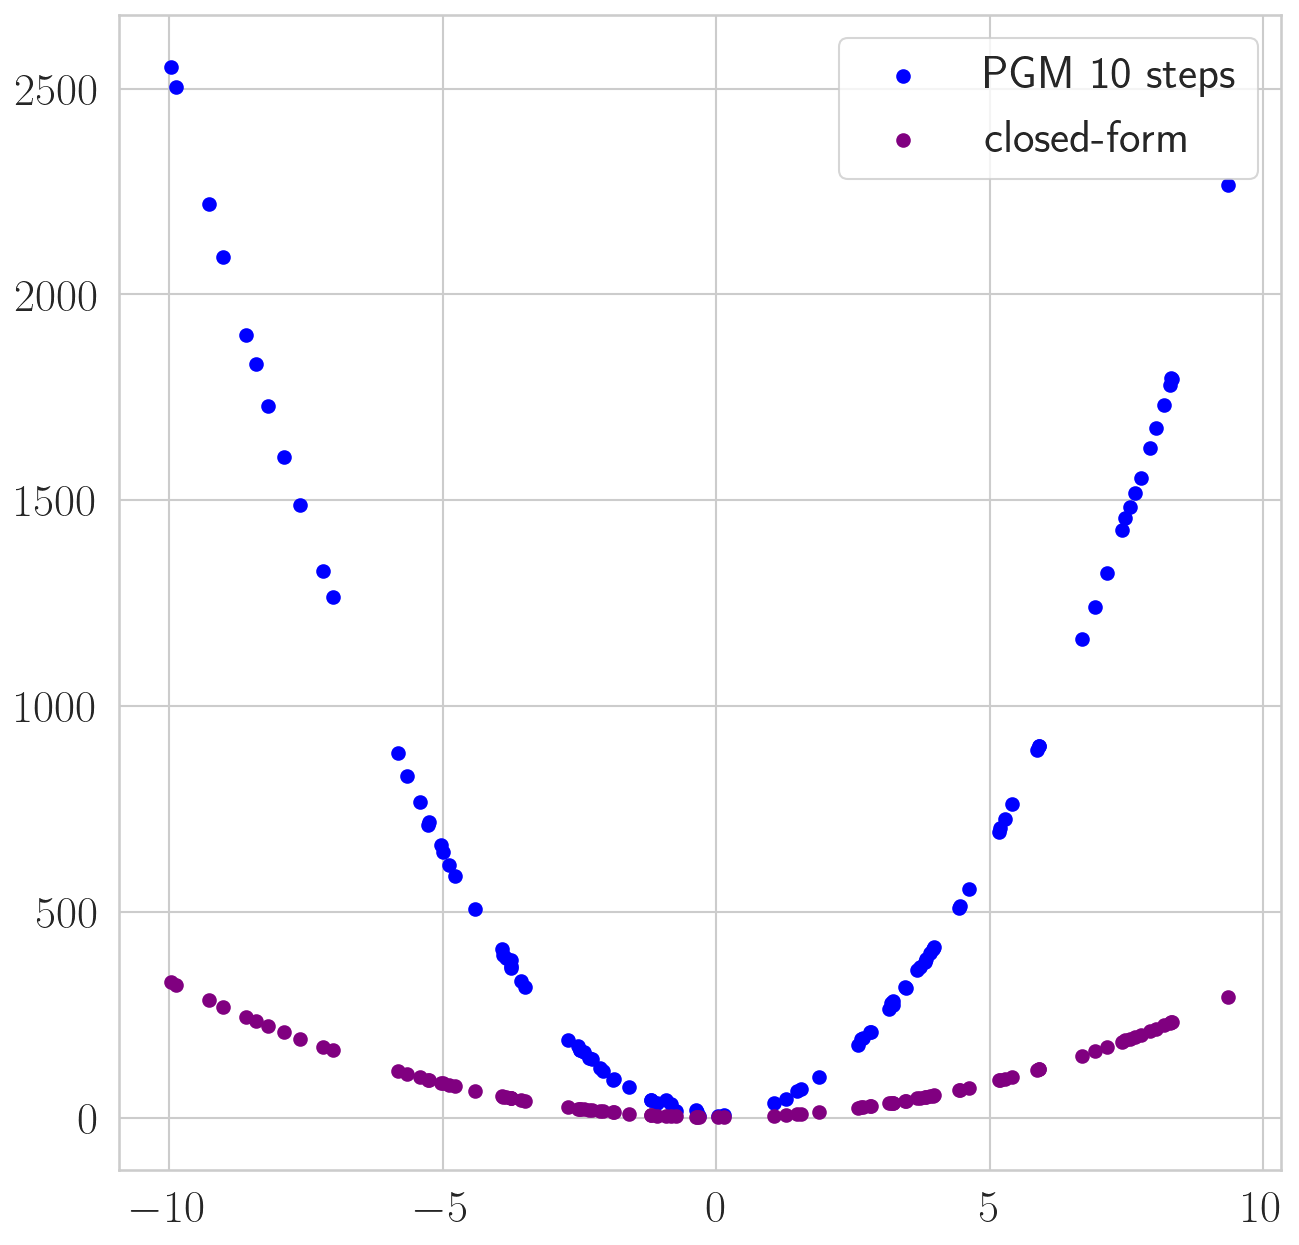

In [22]:
fig = plt.figure(figsize=(10, 10), dpi=150)
x = torch.linspace(-1.,1.,100)
t = torch.Tensor([0.0])
# plt.scatter(x = x.clone().detach().numpy(),y = lqsc.alt_value(500,t,x).clone().detach().numpy(),color='green') 
x = lqsc.path
y = lqsc.value(x)
z = lqsc.path_cost
ind = torch.abs(x[:,0]-t)<1e-3
# plt.scatter(x[ind][:,1].clone().detach().numpy(),y[ind].clone().detach().numpy(),color='orange',,label='PGM value fit');
plt.scatter(x[ind][:,1].clone().detach().numpy(),z[ind].clone().detach().numpy(),color='blue',label='PGM 10 steps');
plt.scatter(x[ind][:,1].clone().detach().numpy(),solution(x[ind]),color='purple',label='closed-form');
plt.legend()
plt.savefig('lqsc_bad_disc.png', dpi=150)

# Multi-scale class

In [20]:
class multi_scale_pgm(object):
    def __init__(self, model_params, lqsc_params, parent, **kwarg):
        self.value_eval = kwarg.get('value_eval', True)
        self.num_samples = model_params['num_samples']
        self.num_time_steps = model_params['num_time_steps']
        self.num_neurons_p = model_params['num_neurons_p']
        self.num_neurons_v = model_params['num_neurons_v']
        self.lr = model_params['lr']
        self.num_epochs = model_params['num_epochs']
        self.x0 = model_params['xmin']
        self.x1 = model_params['xmax']
        self.intervals = [[0,1.]] if model_params['intervals']== None else model_params['intervals']
        self.num_intervals = len(self.intervals)
        self.parent = parent#lambda tx: self.alpha*torch.pow(tx[:,1],2)+self.beta*tx[:,1]+self.gamma
        self.T = self.parent.T
        self.delta = parent.delta/self.num_time_steps
        self.Num_steps = self.parent.Num_steps*self.num_time_steps
        self.a=lqsc_params['a']
        self.b=lqsc_params['b']
        self.c=lqsc_params['c']
        self.d=lqsc_params['d']
        self.A=lqsc_params['A']
        self.B=lqsc_params['B']
        self.sigma=lqsc_params['sigma']
        self.alpha=lqsc_params['alpha']
        self.beta=lqsc_params['beta']
        self.gamma=lqsc_params['gamma']
        self.init_data = model_params['data']
        self.proper_int = lambda t: int((self.T-t)/self.delta)+1 if (self.T-t)/self.delta - int((self.T-t)/self.delta) > self.delta/2 else int((self.T-t)/self.delta)



        self.model= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p,1)
        )
        self.value= torch.nn.Sequential(
            torch.nn.Linear(2, self.num_neurons_v),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_v, self.num_neurons_v),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_v,1)
        )
        
    
    def gen_data(self):
        if self.intervals == [[0,1.]]:
            self.t=torch.zeros([self.num_samples,self.num_intervals])
            #z=np.zeros([M,ite+1])+np.random.rand(M,1)
            # self.z= torch.normal(0, 1, size=(self.num_samples,self.num_time_steps+1))
            self.x_train=torch.FloatTensor(self.num_samples,1).uniform_(self.x0,self.x1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
            self.data=torch.cat((self.t,self.x_train),dim=1)
        else:
            x = self.init_data
            for i,I in enumerate(self.intervals):
                if i==0:
                    data = x[torch.abs(x[:,0]-I[0])<1e-3][:,1]
                    a = torch.quantile(data, 0.1, interpolation='linear')
                    b = torch.quantile(data, 0.9, interpolation='linear')
                    self.t=I[0]*torch.ones([self.num_samples,1])
                    self.x_train=torch.FloatTensor(self.num_samples,1).uniform_(a,b)
                    self.data=torch.cat((self.t,self.x_train),dim=1)
                else:
                    data = x[torch.abs(x[:,0]-I[0])<1e-2]
                    a = torch.quantile(data, 0.1, interpolation='linear')
                    b = torch.quantile(data, 0.9, interpolation='linear')
                    self.t=I[0]*torch.ones([self.num_samples,1])
                    self.x_train=torch.FloatTensor(self.num_samples,1).uniform_(a,b)
                    data = torch.cat((self.t,self.x_train),dim=1)
                    self.data = torch.concat((self.data,data))
        self.z= torch.normal(0, 1, size=(self.data.shape[0],self.num_time_steps+1))

    
    def update(self,x3,psi,i):
        t=(x3[:,0]+self.delta)
        x=x3[:,1]+(self.c*x3[:,1]+self.d*psi)*self.delta+self.sigma*torch.sqrt(self.delta)*self.z[:,i]
        up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
        return up

    def loss_func(self,x2,psi):
        loss=self.a*torch.pow(x2[:,1],2)+self.b*x2[:,1]+self.A*torch.pow(psi,2)+self.B*psi
        return loss

    def loss_func_ter(self,x4):
        # loss=self.alpha*torch.pow(x4[:,1],2)+self.beta*x4[:,1]
        return self.parent(x4)#loss

    def unit(self,x1,i,policy, **kwargs):
        x2 = kwargs.get('disc_policy', x1)
        psi=policy(x2).squeeze(1)
        loss=self.loss_func(x1,psi)
        upd=self.update(x1,psi,i)
        #print('unit print=',psi.shape,los.shape,upd.shape)
        return psi,loss,upd

    def loss_func_total(self,epoch):
        u = self.data
        path = torch.zeros(self.num_samples*self.num_intervals,self.num_time_steps+1,2)
        path_loss=torch.zeros(self.num_samples*self.num_intervals,self.num_time_steps+1)# (i,j)-> (i+1)j
        psi=torch.zeros(self.num_samples*self.num_intervals,self.num_time_steps)
        if (epoch==self.num_epochs-1):
            self.state_var=u.clone().detach()   
            path[:,0,:] = u.clone().detach()
        for i in range(self.num_time_steps):
            psi_run,loss_run,u_run=self.unit(u,i,self.model)
            #print('los func=',psi_run.shape,loss_run.shape)
            path_loss[:,i]=loss_run*self.delta
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==self.num_epochs-1):
                self.state_var = torch.concat((self.state_var,u.clone().detach()), axis=0)  
                path[:,i+1,:] = u.clone().detach()     
        path_loss[:,-1]=self.loss_func_ter(u)
        if (epoch==self.num_epochs-1):
            a = torch.flip(path_loss, dims = (1,))
            b = torch.cumsum(a, dim=1)
            c = torch.flip(b, dims = (1,))
            d = torch.transpose(c,0,1)
            self.path_cost = d.reshape(self.num_intervals*(self.num_time_steps+1)*self.num_samples,1).clone().detach()
            p = torch.transpose(path,0,1)
            self.path = p.reshape(self.num_intervals*(self.num_time_steps+1)*self.num_samples,2).clone().detach()            
        loss_=torch.sum(path_loss,dim=1)
        return loss_
    
    def train_it(self):
        self.gen_data()
        start=time.time()
        cost_ar=[]
        optimizer = optim.Adam(self.model.parameters(), self.lr)
        for epoch in range(self.num_epochs):
            optimizer.zero_grad()
            cost = self.loss_func_total(epoch)
            loss = torch.mean(cost)
            loss.backward()
            optimizer.step()
            cost_ar.append(loss)
            #print(loss.item())
            if (epoch % 500==0):
                print("At epoch {} the mean cost is {}.".format(epoch,loss.detach()))
        end=time.time()
        total_time=end-start
        print('Training time=',total_time)
        self.path_full, self.path_cost_full = self.optimal_path(self.parent.num_samples)

        if self.value_eval:
            self.train_val_fnc()


    def train_val_fnc(self,**kwargs):
        M = kwargs.get('num_epochs', self.num_epochs)
        K = kwargs.get('num_samples', self.num_samples)
        permuted_range = np.random.permutation(self.num_intervals*(self.num_time_steps+1)*self.num_samples)
        tx = self.path_full[permuted_range,:]
        val = self.path_cost_full[permuted_range,:]
        optimizer_v = optim.Adam(self.value.parameters(), self.lr)
        start=time.time()
        E_ = -1e9
        E = 1e9
        m = 0
        while (np.abs((E-E_)/E_)>1e-4) and ( m <= M):
            loss_v = torch.nn.MSELoss()(self.value(tx),val)
            optimizer_v.zero_grad()
            loss_v.backward()
            optimizer_v.step()
            m += 1
        end=time.time()
        total_time=end-start
        print('value function training time=',total_time)        
        
    def __call__(self, tx):
        return self.value(tx).squeeze(-1)
    
    def policy(self,tx):
        return self.model(tx)    
        
    def optimal_path(self,num_samples):
        N = self.Num_steps+1
        path = torch.zeros(num_samples,N,2)
        path_loss=torch.zeros(num_samples,N)
        t=torch.zeros([num_samples,1])
        self.z= torch.normal(0, 1, size=(num_samples,N))
        x=torch.FloatTensor(num_samples,1).uniform_(self.x0,self.x1)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
        path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
        for i in range(N-1):
            _,loss_run,u_run=self.unit(path[:,i,:],i,self.model)
            path[:,i+1,:] = u_run.clone().detach() 
            path_loss[:,i]=loss_run*self.delta   
        path_loss[:,-1]=self.loss_func_ter(u_run)
        p = torch.transpose(path,0,1)
        path = p.reshape(num_samples*N,2).clone().detach()   
        a = torch.flip(path_loss, dims = (1,))
        b = torch.cumsum(a, dim=1)
        c = torch.flip(b, dims = (1,))
        d = torch.transpose(c,0,1)
        path_cost = d.reshape(num_samples*N,1).clone().detach()         
        return path, path_cost
        

    def cost_eval(self,policy,num_samples,x0, **kwargs):
        M = kwargs.get('policy_update_lag', 1)
        if  self.Num_steps%M!=0:
            raise ValueError(r"The number of time steps {:d} in this PGM instance must be divisible by the number of time steps {:d} in the input of disc_cost_eval(self,policy,num_samples,num_time_steps,x0).".format(self.num_time_steps,M))
        else:
            N = self.Num_steps+1
            val=torch.zeros([num_samples])
            t=torch.zeros([num_samples,1])
            self.z= torch.normal(0, 1, size=(num_samples,N))
            x = x0*torch.ones([num_samples,1])
            full_path = torch.zeros(num_samples,N,2)
            full_path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
            for i in range(N-1):
                last_coarse_point = full_path[:,int(i/M),:]
                _,loss_run,u_run=self.unit(full_path[:,i,:],i,policy,disc_policy = last_coarse_point)
                full_path[:,i+1,:] = u_run.clone().detach() 
                val += (loss_run*self.delta).clone().detach()
            val += self.parent.loss_func_ter(u_run).clone().detach()
            return torch.mean(val)     
        
        
   # We need the policy to only be evaluated at discrete points and stays unchanged until the next point.
    # def alt_value(self,num_samples,t,x):
    #     M = x.shape[0]
    #     x0 = x.repeat(num_samples).unsqueeze(-1)
    #     t0 = t.repeat(num_samples*M).unsqueeze(-1)
    #     N = self.proper_int(t)
    #     full_path = torch.zeros(num_samples*M,N+1,2)
    #     # full_path_loss=torch.zeros(M,num_samples,N)
    #     self.z= torch.normal(0, 1, size=(M*num_samples,N))
    #     val=torch.zeros(num_samples*M)
    #     full_path[:,0,:] = torch.cat((t0,x0),dim=1).clone().detach()
    #     if N==0:
    #         u_run = full_path[:,0,:]
    #     else:
    #         for i in range(N):
    #             _,loss_run,u_run=self.unit(full_path[:,i,:],i,self.policy)
    #             full_path[:,i+1,:] = u_run.clone().detach() 
    #             val += (loss_run*self.delta).clone().detach()
    #     val += self.loss_func_ter(u_run).clone().detach()
    #     w = torch.reshape(val,[num_samples,M])
    #     return torch.mean(w,axis=0)

    # def __call__(self, tx, **kwargs):
    #     num_samples = kwargs.get('num_samples',500)
    #     t_set = set(tx[:,0].clone().detach().numpy())
    #     val = torch.zeros(tx.shape[0])
    #     for ti in t_set:
    #         ind = tx[:,0] == ti
    #         if ti>=self.T-self.delta/2:
    #             val[ind] = self.loss_func_ter(tx[ind]).clone().detach()
    #         else:
    #             val[ind] = self.alt_value(num_samples,torch.tensor(ti),tx[ind][:,1])
    #     return val                
         
    

# Multi-scale PGM 1

## Multi-scale parameters

In [21]:
ms1_model_params = {
    'num_samples':50,
    'num_time_steps':5,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 8e-3,
    'num_epochs' : 3000,
    'xmin' : model_params['xmin'],
    'xmax' : model_params['xmax'],
    'intervals' : [[k*lqsc.T/lqsc.num_time_steps, (k+1)*lqsc.T/lqsc.num_time_steps] for k in range(lqsc.num_time_steps) if k%2==0], # a list of numbers between 0 to num_intervals-1,[4./10.,5./10.],[7./10.,8./10.],
    'data': lqsc.path
    }

In [22]:
ms1_model_params['intervals']

[[0.0, 0.25], [0.5, 0.75], [1.0, 1.25]]

## instance creation

In [23]:
ms1 = multi_scale_pgm(ms1_model_params,lqsc_params, lqsc, value_eval=True)

## Training

In [24]:
ms1.train_it()

At epoch 0 the mean cost is 391.7047547673281.
At epoch 500 the mean cost is 43.98108250731351.
At epoch 1000 the mean cost is 43.97447278814339.
At epoch 1500 the mean cost is 43.96981533371046.
At epoch 2000 the mean cost is 43.96415821109504.
At epoch 2500 the mean cost is 43.95794032590293.
Training time= 46.68579697608948
value function training time= 1.008465051651001


In [25]:
dfv_ms = pd.DataFrame(np.zeros([K1*L,3]),columns=[1,'C','closed']); 
for i,_ in dfv_ms.iterrows(): 
    dfv_ms.loc[i,1] = ms1.cost_eval(ms1.policy,1,X1[i%K1]).clone().detach().numpy()
    dfv_ms.loc[i,'C'] = lqsc.cost_eval(lqsc.policy,1,X1[i%K1]).clone().detach().numpy()
dfv_ms['closed'] = list(solution(tx1))*L
dfv_ms['index'] = [str(np.round(x,3)) for x in X1.clone().detach().numpy()]*L
dfv_ms.set_index('index',inplace=True,drop=True)
dfv_ms


,1,C,closed
index,,,
-2.0,29.944230,121.389415,14.065820
-1.789,24.769878,88.216793,11.443217
-1.579,18.427447,74.229424,9.114538
-1.368,14.296266,55.960529,7.079783
-1.158,10.233281,34.967535,5.338953
...,...,...,...
1.158,12.447242,41.714838,5.588819
1.368,14.967147,52.354229,7.375080
1.579,19.606972,66.362401,9.455265


/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/2152127763.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/2152127763.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")


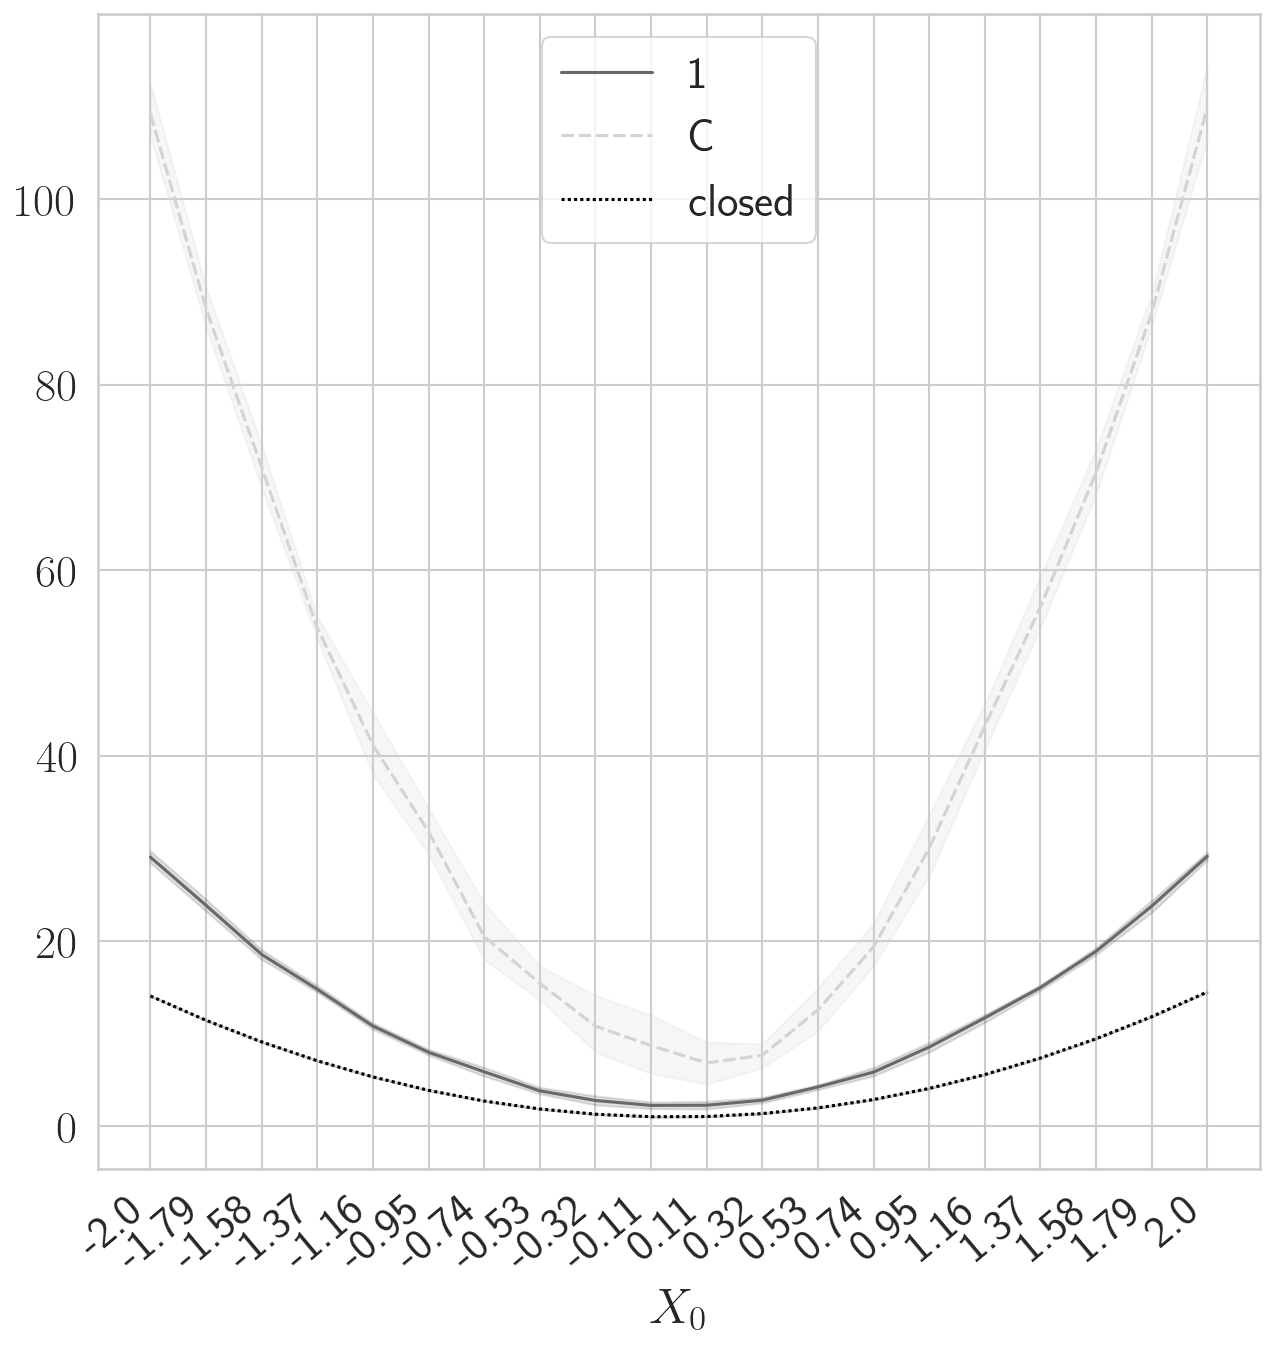

In [26]:
plt.figure(figsize=(10,10),dpi=150);
g = sns.lineplot(data=dfv_ms, palette=['dimgrey', 'lightgrey', 'black']);
g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
g.set_xlabel(r"$X_0$");
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")
s1 = str(model_params['num_samples'])
s2 = str(ms1_model_params['num_samples'])
plt.savefig(s1+"_"+s2+version+".png")

In [27]:
df_ms = pd.DataFrame(np.zeros([K*L,3]),columns=[1,'C','closed']); 
for i,_ in df_ms.iterrows(): 
    df_ms.loc[i,1] = ms1.cost_eval(ms1.policy,1,X[i%K]).clone().detach().numpy()
    df_ms.loc[i,'C'] = lqsc.cost_eval(lqsc.policy,1,X[i%K]).clone().detach().numpy()
df_ms['closed'] = list(solution(tx))*L
df_ms['index'] = [str(np.round(x,3)) for x in X.clone().detach().numpy()]*L
df_ms.set_index('index',inplace=True,drop=True)
df_ms

,1,C,closed
index,,,
-10.0,672.563623,2571.669344,331.522635
-7.778,413.431473,1558.086994,200.766526
-5.556,209.455951,796.608311,102.759386
-3.333,78.780667,289.972284,37.501217
-1.111,9.326221,36.306021,4.992017
...,...,...,...
1.111,10.484857,39.778175,5.231788
3.333,78.925626,288.919033,38.220529
5.556,209.135283,796.853149,103.958240


In [28]:
df_box_ms1 = ((df_ms[1]-df_ms['closed'])/df_ms['closed']).reset_index()
df_box_ms1.columns = ['x', 'rel_error']
df_box_ms1['Method'] = 'multi-scale1'
df_box_msc = pd.concat([df_box_ms1,df_box_co],axis=0)
df_box_msc

,x,rel_error,Method
0,-10.0,1.028711,multi-scale1
1,-7.778,1.059265,multi-scale1
2,-5.556,1.038315,multi-scale1
3,-3.333,1.100750,multi-scale1
4,-1.111,0.868227,multi-scale1
...,...,...,...
95,1.111,6.404373,coarse
96,3.333,6.700694,coarse
97,5.556,6.689900,coarse
98,7.778,6.722203,coarse


/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/3941098221.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")


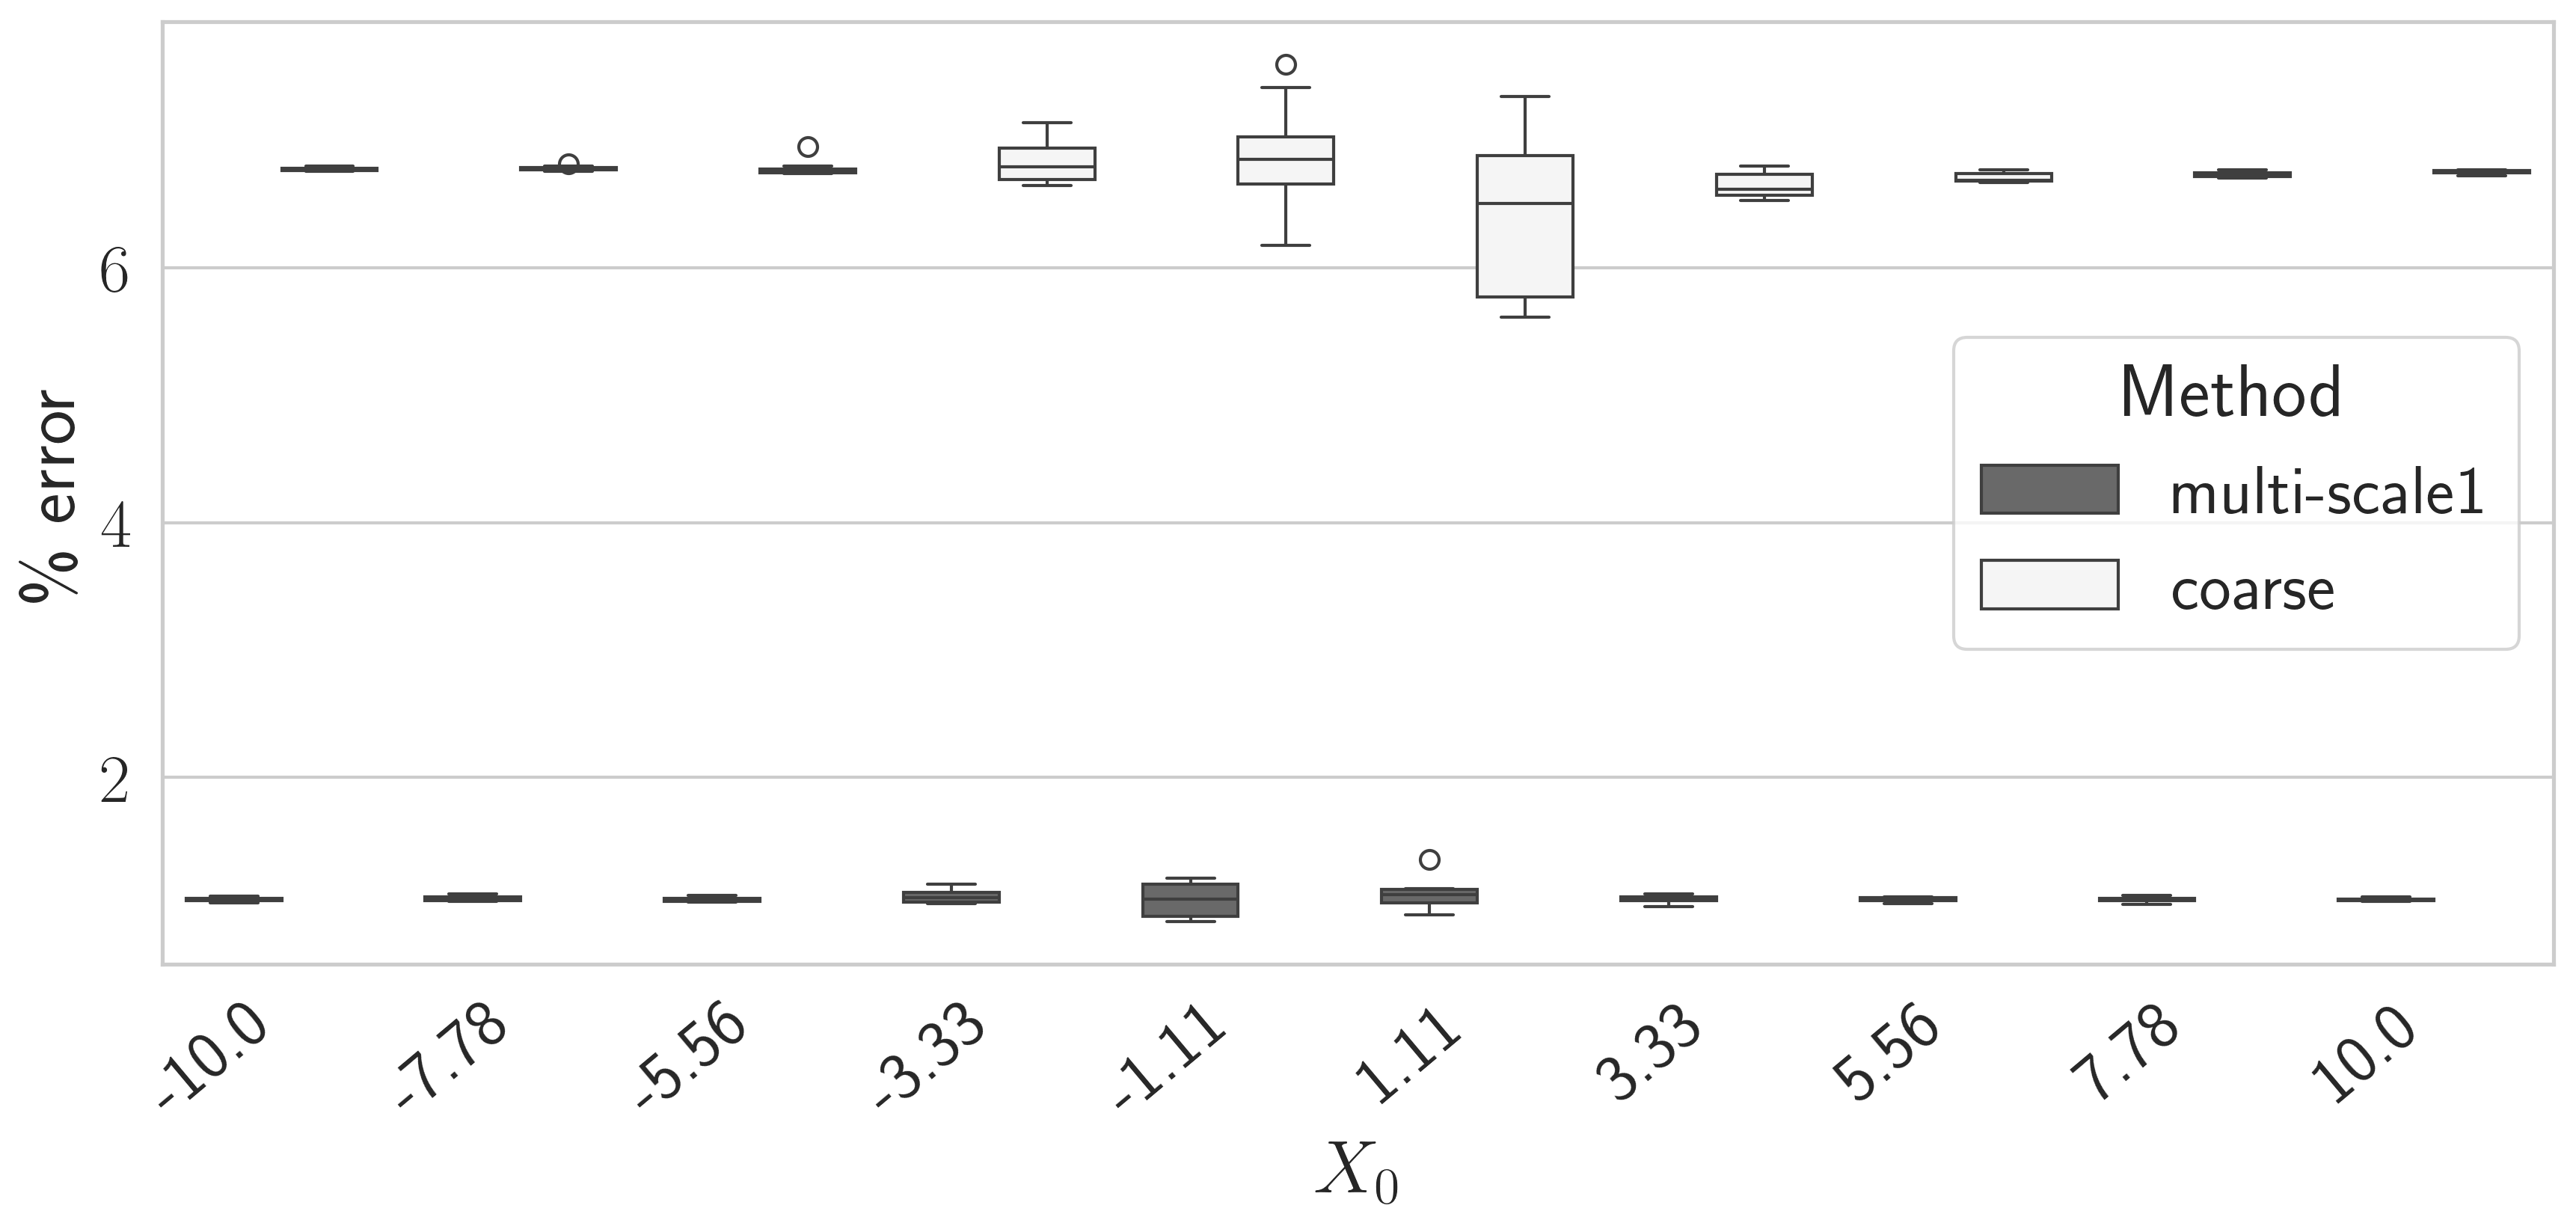

In [29]:
fig = plt.figure(figsize=(12,6),dpi=300);
sns.set_style("whitegrid");
g = sns.boxplot(data=df_box_msc, y = 'rel_error', x = 'x', hue='Method', palette=['dimgrey', 'whitesmoke']);#, boxprops=dict(facecolor='none'));
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")
g.set_xlabel(r"$X_0$");
g.set_ylabel(r"\% error");
# g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="center");
plt.tight_layout();

Relative $L^1$ error $= 189.50\%$

Relative $L^2$ error $= 109.55\%$

Relative $L^\infty$ error $= 106.78\%$

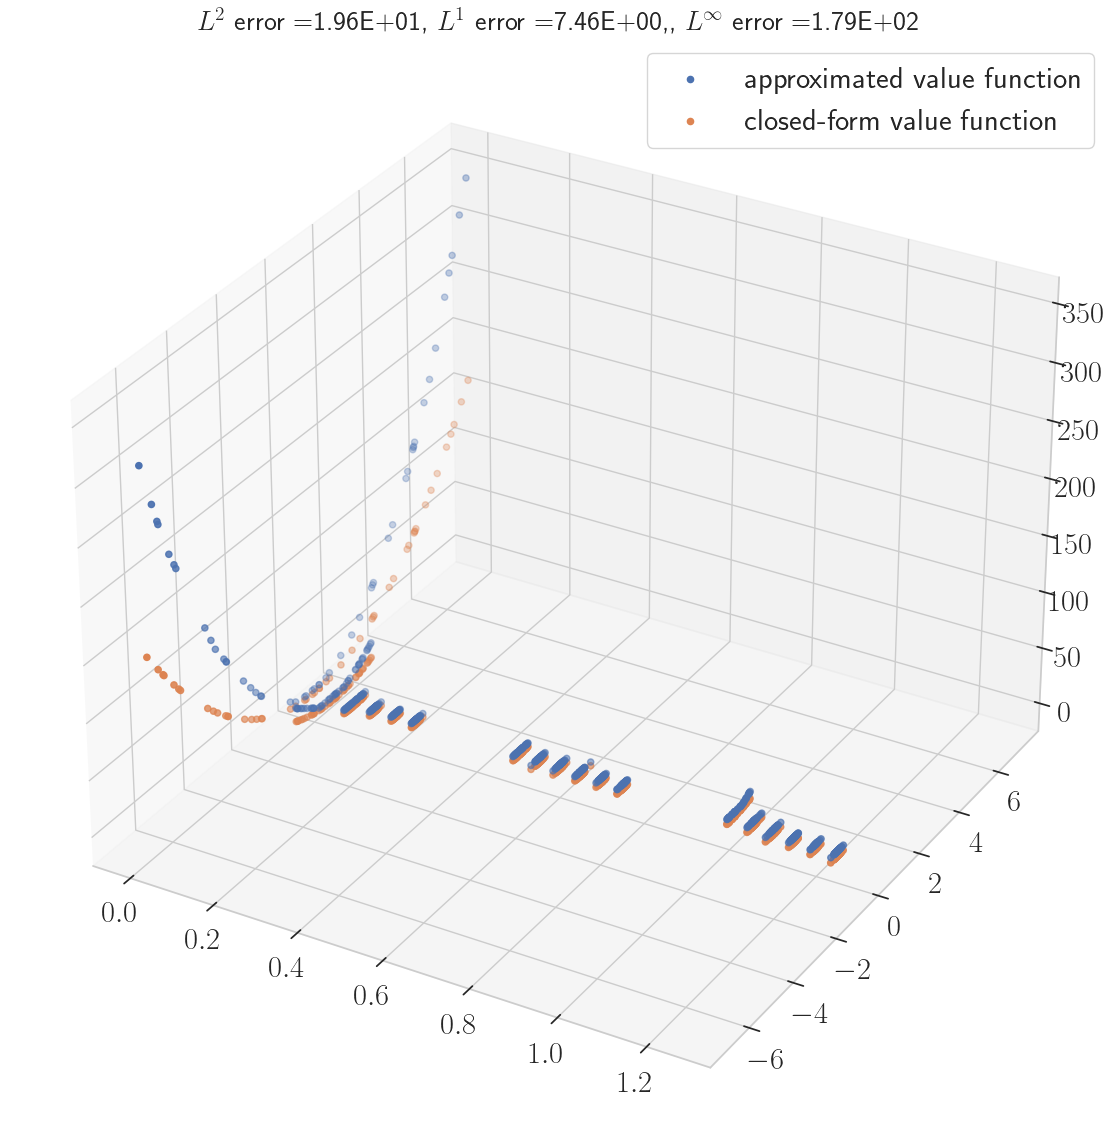

In [30]:
xyz = torch.concat((ms1.path,ms1(ms1.path).unsqueeze(-1)),dim=1).clone().detach().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],label='approximated value function')
ax.scatter(xyz[:,0], xyz[:,1], solution(xyz[:,0:2]),label='closed-form value function')
ax.legend();
ax.set_title(r"$L^2$ error ={:.2E}, $L^1$ error ={:.2E},, $L^\infty$ error ={:.2E}".format(
    np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2))),
    np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
    np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2])),
    ), fontsize=20)
plt.tight_layout();

display(Markdown(r"Relative $L^1$ error $= {:.2f}\%$".format(np.mean(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.mean(np.abs(solution(xyz[:,0:2])))*100)))
display(Markdown(r"Relative $L^2$ error $= {:.2f}\%$".format(np.sqrt(np.mean(np.power(solution(xyz[:,0:2])-xyz[:,2],2)))/np.sqrt(np.mean(np.power(solution(xyz[:,0:2]),2)))*100)))
display(Markdown(r"Relative $L^\infty$ error $= {:.2f}\%$".format(np.max(np.abs(solution(xyz[:,0:2])-xyz[:,2]))/np.max(np.abs(solution(xyz[:,0:2])))*100)))

# Multi-scale PGM 2

## Multi-scale parameters

In [31]:
ms2_model_params = {
    'num_samples':10,
    'num_time_steps':5,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 8e-3,
    'num_epochs' : 3000,
    'xmin' : model_params['xmin'],
    'xmax' : model_params['xmax'],
    'intervals' : [[k*ms1.T/ms1.Num_steps, (k+1)*ms1.T/ms1.Num_steps] for k in range(ms1.Num_steps) if k%6==0], # a list of numbers between 0 to num_intervals-1,[4./10.,5./10.],[7./10.,8./10.],
    'data': ms1.path_full
    }


## instance creation

In [32]:
ms2 = multi_scale_pgm(ms2_model_params,lqsc_params, ms1, value_eval=False)

## Training

In [33]:
ms2.train_it()

At epoch 0 the mean cost is 56.808914164082964.
At epoch 500 the mean cost is 20.34272413126119.
At epoch 1000 the mean cost is 20.32408404160273.
At epoch 1500 the mean cost is 20.31071025777713.
At epoch 2000 the mean cost is 20.305928764993798.
At epoch 2500 the mean cost is 20.30003391983279.
Training time= 4.701241970062256


In [34]:
ms2_model_params['intervals']

[[0.0, 0.05], [0.3, 0.35], [0.6, 0.65], [0.9, 0.95], [1.2, 1.25]]

In [35]:
dfv_ms = pd.DataFrame(np.zeros([K1*L,3]),columns=[1,'C','closed']); 
for i,_ in dfv_ms.iterrows(): 
    dfv_ms.loc[i,1] = ms1.cost_eval(ms1.policy,1,X1[i%K1]).clone().detach().numpy()
    dfv_ms.loc[i,2] = ms2.cost_eval(ms2.policy,1,X1[i%K1]).clone().detach().numpy()
    dfv_ms.loc[i,'C'] = lqsc.cost_eval(lqsc.policy,1,X1[i%K1]).clone().detach().numpy()
dfv_ms['closed'] = list(solution(tx1))*L
dfv_ms['index'] = [str(np.round(x,3)) for x in X1.clone().detach().numpy()]*L
dfv_ms.set_index('index',inplace=True,drop=True)
dfv_ms

,1,C,closed,2
index,,,,
-2.0,28.692740,105.323759,14.065820,21.592323
-1.789,24.241742,83.033036,11.443217,18.051711
-1.579,20.424218,67.597314,9.114538,19.134551
-1.368,14.888619,54.300129,7.079783,14.010341
-1.158,11.363574,38.512371,5.338953,10.385205
...,...,...,...,...
1.158,10.526851,39.648467,5.588819,13.980477
1.368,14.812148,49.909726,7.375080,14.779838
1.579,20.247017,73.940165,9.455265,15.866173


In [36]:
dfv_ms.loc[dfv_ms.index[150]]

,1,C,closed,2
index,,,,
0.105,2.531671,6.827718,1.066379,5.222884
0.105,1.592227,5.977693,1.066379,5.494802
0.105,2.140406,12.644222,1.066379,5.097785
0.105,4.521026,9.110148,1.066379,6.252318
0.105,3.278005,4.047497,1.066379,5.552781
0.105,2.276887,3.732557,1.066379,7.284347
0.105,2.169246,8.848637,1.066379,6.098281
0.105,2.155042,14.362992,1.066379,7.296438
0.105,2.411810,3.820170,1.066379,8.461018


/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/3804772904.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/3804772904.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")


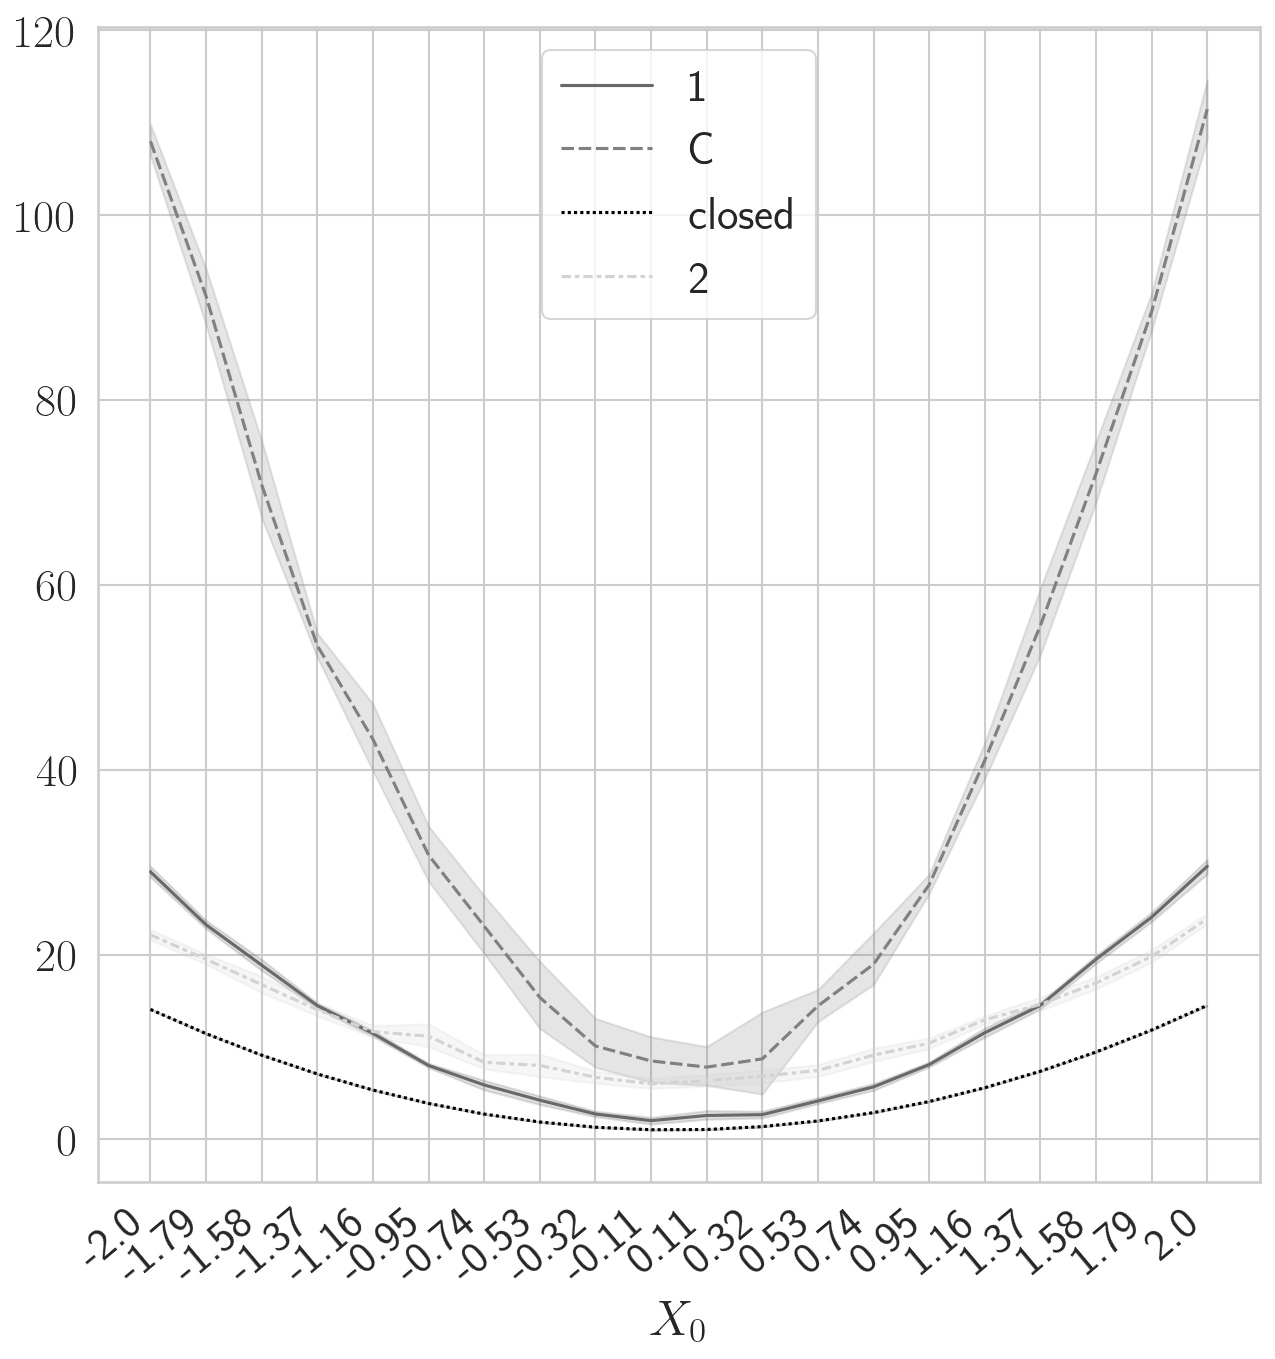

In [37]:
plt.figure(figsize=(10,10),dpi=150);
g = sns.lineplot(data=dfv_ms, palette=['dimgrey', 'grey', 'black', 'lightgrey']);
g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
g.set_xlabel(r"$X_0$");
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")
s1 = str(model_params['num_samples'])
s2 = str(ms1_model_params['num_samples'])
plt.savefig(s1+"_"+s2+version+".png")

In [38]:
df_ms2 = pd.DataFrame(np.zeros([K*L,4]),columns=[1,2,'C','closed']); 
for i,_ in df_ms2.iterrows(): 
    df_ms2.loc[i,1] = ms1.cost_eval(ms1.policy,1,X[i%K]).clone().detach().numpy()
    df_ms2.loc[i,2] = ms2.cost_eval(ms2.policy,1,X[i%K]).clone().detach().numpy()
    df_ms2.loc[i,'C'] = lqsc.cost_eval(lqsc.policy,1,X[i%K]).clone().detach().numpy()
df_ms2['closed'] = list(solution(tx))*L
df_ms2['index'] = [str(np.round(x,3)) for x in X.clone().detach().numpy()]*L
df_ms2.set_index('index',inplace=True,drop=True)
df_ms2


,1,2,C,closed
index,,,,
-10.0,686.095043,403.933303,2591.438319,331.522635
-7.778,407.408861,245.718099,1573.449050,200.766526
-5.556,210.951273,126.371449,793.648005,102.759386
-3.333,76.191634,52.410576,290.180743,37.501217
-1.111,10.353639,12.045292,44.625649,4.992017
...,...,...,...,...
1.111,11.671487,11.284674,37.334967,5.231788
3.333,79.334325,52.939627,291.358997,38.220529
5.556,209.353235,130.382198,812.341391,103.958240


In [39]:
df_box_ms2 = ((df_ms2[2]-df_ms2['closed'])/df_ms2['closed']).reset_index()
df_box_ms2.columns = ['x', 'rel_error']
df_box_ms2['Method'] = 'multi-scale2'
# df_box_ms = pd.concat([df_box_ms1,df_box_ms2],axis=0)
df_box_msc2 = pd.concat([df_box_ms2,df_box_msc],axis=0)
df_box_msc2['x'] = df_box_msc2['x'].astype('float64')

/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/3031217305.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")


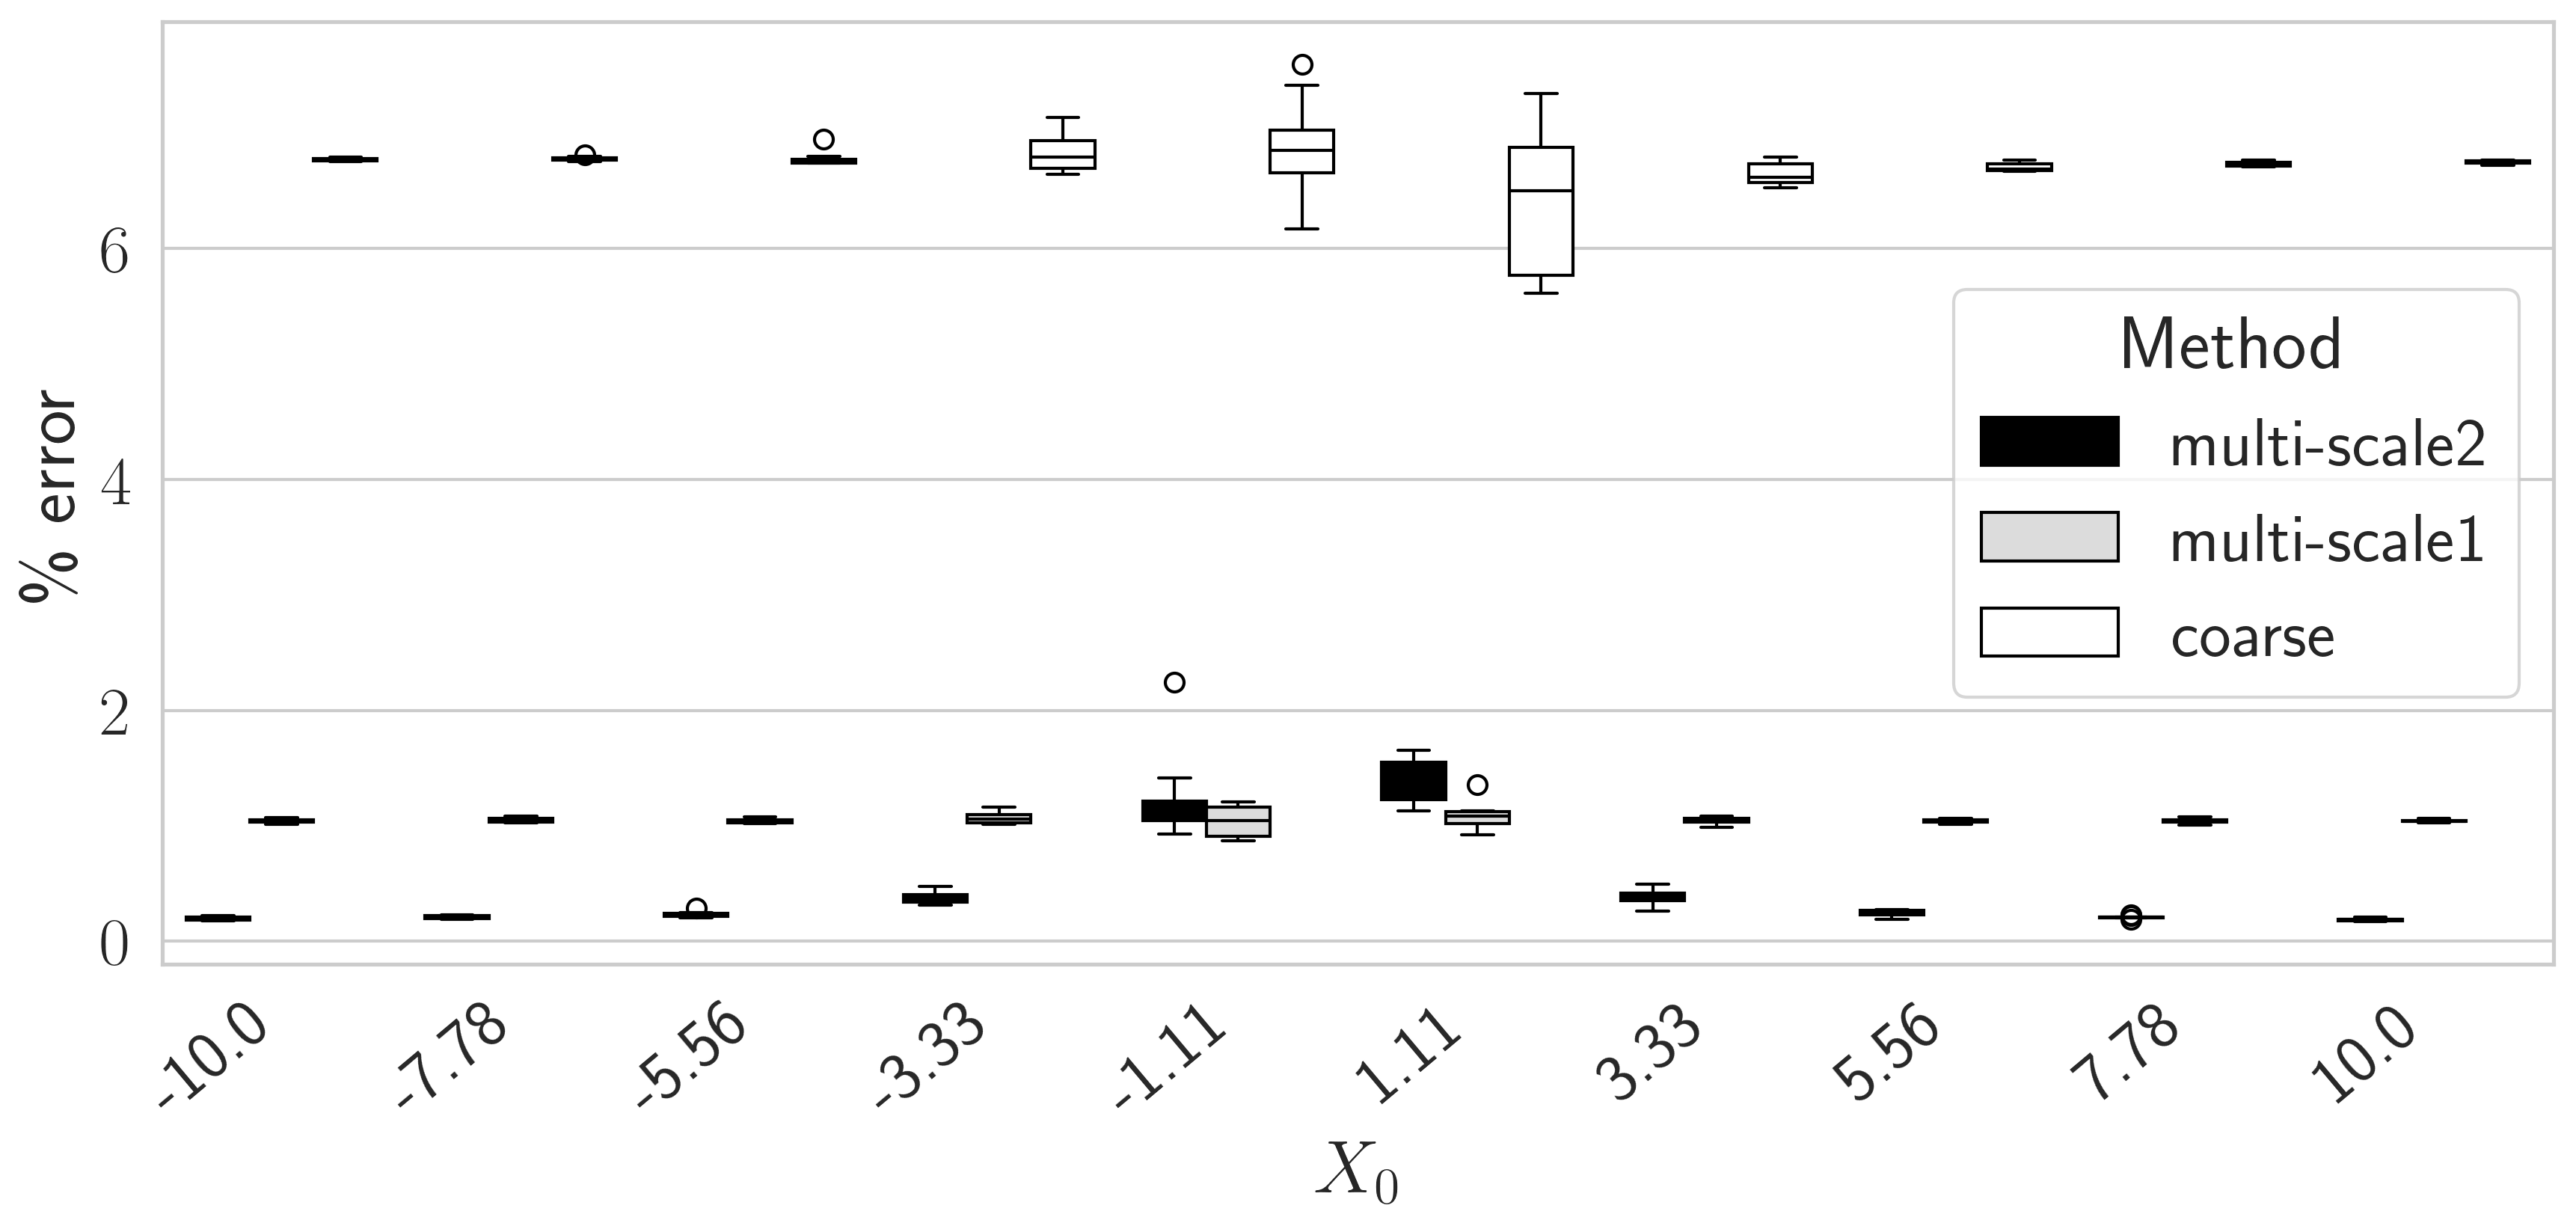

In [40]:
fig = plt.figure(figsize=(12,6),dpi=300);
sns.set_style("whitegrid");
g = sns.boxplot(data=df_box_msc2, y = 'rel_error', x = 'x', hue='Method', palette=[ 'black', 'gainsboro', 'white']);#, boxprops=dict(facecolor='none'));
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")
g.set_xlabel(r"$X_0$");
g.set_ylabel(r"\% error");
# g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="center");
plt.tight_layout();

# Brute-force

## Parameters

In [41]:
bf_model_params = {
    'num_samples':100,
    'num_time_steps':ms2.Num_steps,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 8e-3,
    'num_epochs' : 3000,
    'xmin' : model_params['xmin'],
    'xmax' : model_params['xmax'],
    'intervals' : None # a list of numbers between 0 to num_intervals-1
    }

## Instance creation

In [42]:
bf_lqsc = pgm(bf_model_params,lqsc_params, t1, value_eval=False)

## Training

In [43]:
bf_lqsc.train_it()

At epoch 1500 the mean cost is 147.84755119203342.
Training time= 68.89081597328186
Last training epoch was 1702


In [44]:
dfv_bf = pd.DataFrame(np.zeros([K1*L,5]),columns=[1,'closed','C','MS1', 'MS2']); 
for i,_ in dfv_bf.iterrows(): 
    # df_bf.loc[i,10] = bf_lqsc.cost_eval(lqsc.policy,3000,X[i%K],policy_update_lag=10).clone().detach().numpy()
    dfv_bf.loc[i,1] = bf_lqsc.cost_eval(bf_lqsc.policy,1,X1[i%K1]).clone().detach().numpy()
    dfv_bf.loc[i,'C'] = lqsc.cost_eval(lqsc.policy,1,X1[i%K1]).clone().detach().numpy()
    dfv_bf.loc[i,'MS1'] = ms1.cost_eval(ms1.policy,1,X1[i%K1]).clone().detach().numpy()
    dfv_bf.loc[i,'MS2'] = ms2.cost_eval(ms2.policy,1,X1[i%K1]).clone().detach().numpy()    
dfv_bf['closed'] = list(solution(tx1))*L
dfv_bf['index'] = [str(np.round(x,3)) for x in X1.clone().detach().numpy()]*L
dfv_bf.set_index('index',inplace=True,drop=True)    
dfv_bf.rename(columns={1:'brute-force', 'closed':'closed-form','C':'coarse', 'MS1': 'multi-scale1', 'MS2': 'multi-scale2'},inplace=True)


/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/684849385.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/684849385.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")


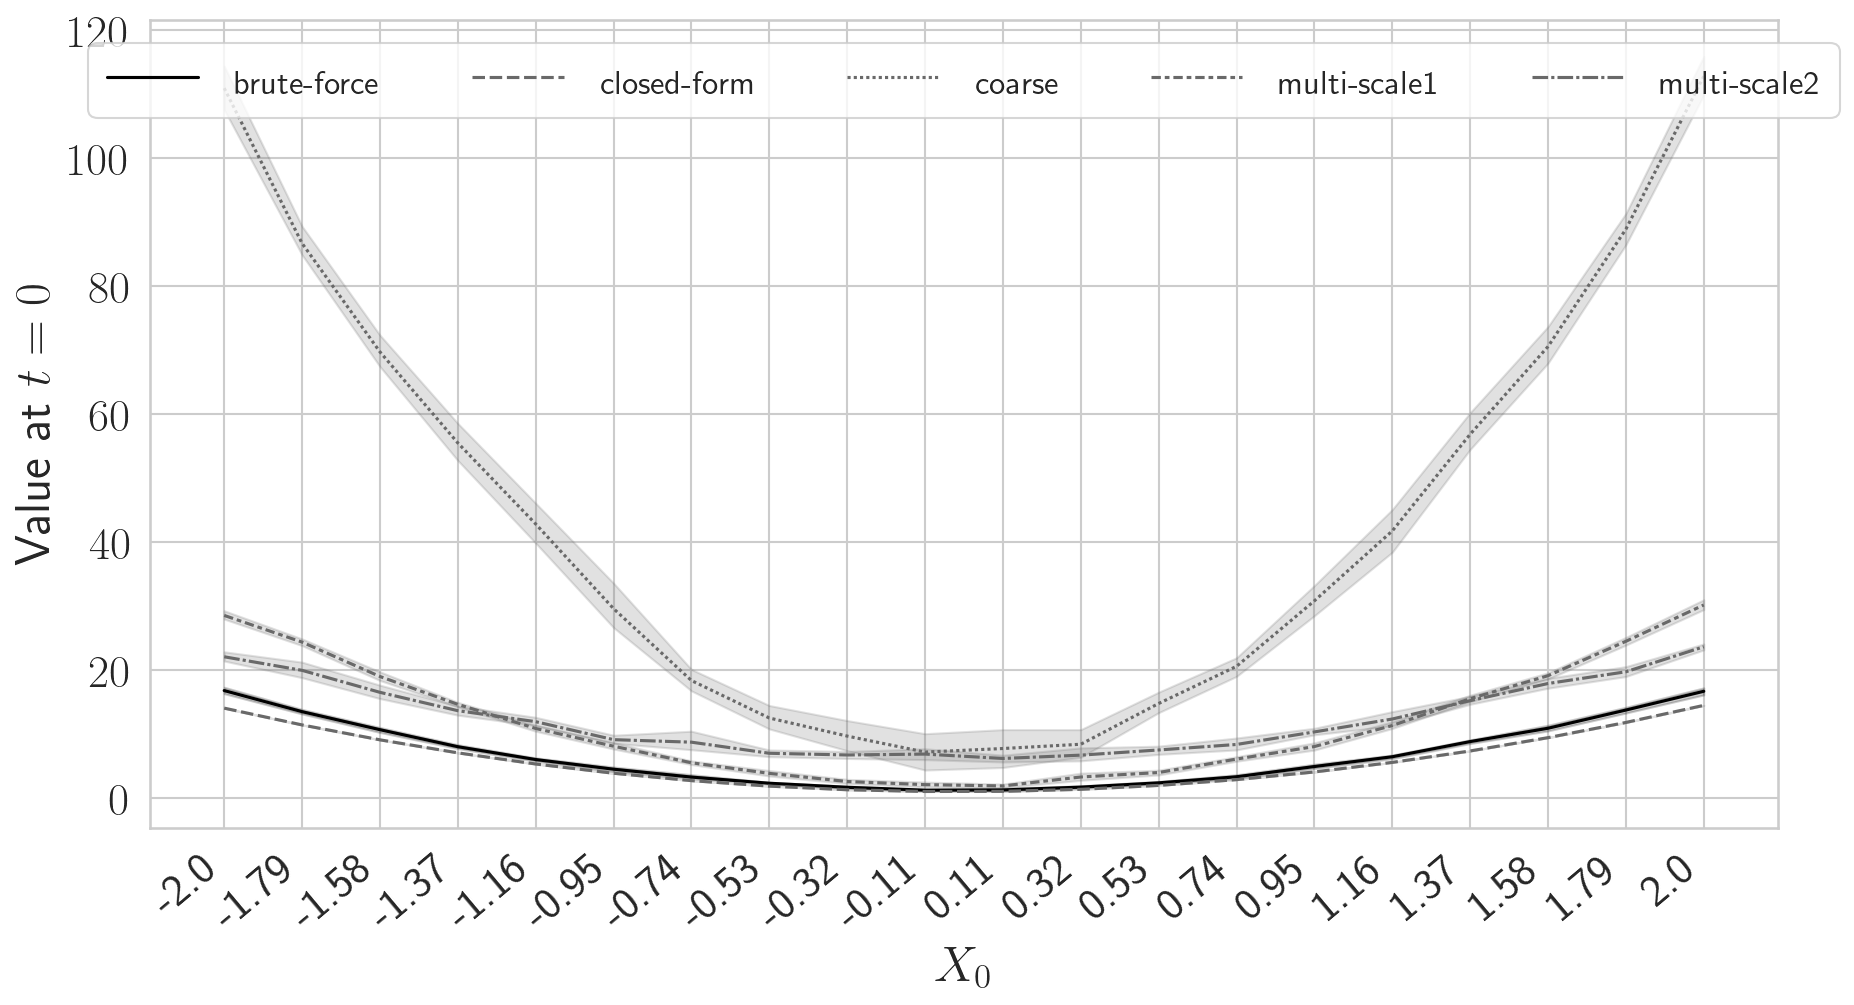

In [45]:
plt.figure(figsize=(14,7),dpi=150);
sns.set_style("whitegrid");
g = sns.lineplot(data=dfv_bf, palette=['black', 'dimgrey', 'dimgrey', 'dimgrey','dimgrey']);
g.set_xticklabels(list(np.round(X1.clone().detach().numpy(),2)));
g.set_xlabel(r"$X_0$");
g.set_ylabel(r"Value at $t=0$");
sns.move_legend(g, "upper center", bbox_to_anchor=(.5, 1.), ncol=5, title=None)
plt.setp(g.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='12') # for legend title
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")
s1 = str(model_params['num_samples'])
s2 = str(ms1_model_params['num_samples'])
plt.savefig("bf_"+s1+"_"+s2+version+".png")

In [46]:
df_bf = pd.DataFrame(np.zeros([K*L,5]),columns=[1,'closed','C','MS1', 'MS2']); 
for i,_ in df_bf.iterrows(): 
    # df_bf.loc[i,10] = bf_lqsc.cost_eval(lqsc.policy,3000,X[i%K],policy_update_lag=10).clone().detach().numpy()
    df_bf.loc[i,1] = bf_lqsc.cost_eval(bf_lqsc.policy,1,X[i%K]).clone().detach().numpy()
    df_bf.loc[i,'C'] = lqsc.cost_eval(lqsc.policy,1,X[i%K]).clone().detach().numpy()
    df_bf.loc[i,'MS1'] = ms1.cost_eval(ms1.policy,1,X[i%K]).clone().detach().numpy()
    df_bf.loc[i,'MS2'] = ms2.cost_eval(ms2.policy,1,X[i%K]).clone().detach().numpy()
df_bf['closed'] = list(solution(tx))*L
df_bf['index'] = [str(np.round(x,3)) for x in X.clone().detach().numpy()]*L
df_bf.set_index('index',inplace=True,drop=True)    
df_bf

,1,closed,C,MS1,MS2
index,,,,,
-10.0,388.180088,331.522635,2587.082848,676.264467,389.390383
-7.778,237.310031,200.766526,1567.037962,416.790148,242.928218
-5.556,121.752944,102.759386,804.554659,212.087275,124.573747
-3.333,43.376873,37.501217,290.808554,78.053619,49.813226
-1.111,5.771743,4.992017,37.592442,11.061914,11.037646
...,...,...,...,...,...
1.111,7.068760,5.231788,44.830075,10.535423,12.075613
3.333,46.401183,38.220529,290.233849,80.046751,54.534182
5.556,119.242968,103.958240,798.614057,212.976955,127.356446


In [47]:
df_box_bf = ((df_bf[1]-df_bf['closed'])/df_bf['closed']).reset_index()
df_box_bf.columns = ['x', 'rel_error']
df_box_bf['Method'] = 'brute-force'
df_box_bfmsc = pd.concat([df_box_bf,df_box_msc2],axis=0)
df_box_bfmsc

,x,rel_error,Method
0,-10.0,0.170901,brute-force
1,-7.778,0.182020,brute-force
2,-5.556,0.184835,brute-force
3,-3.333,0.156679,brute-force
4,-1.111,0.156195,brute-force
...,...,...,...
95,1.111,6.404373,coarse
96,3.333,6.700694,coarse
97,5.556,6.689900,coarse
98,7.778,6.722203,coarse


/var/folders/x2/jwwtmhbn3kzfqtgxfhgs14zm0000gp/T/ipykernel_56833/2870654211.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


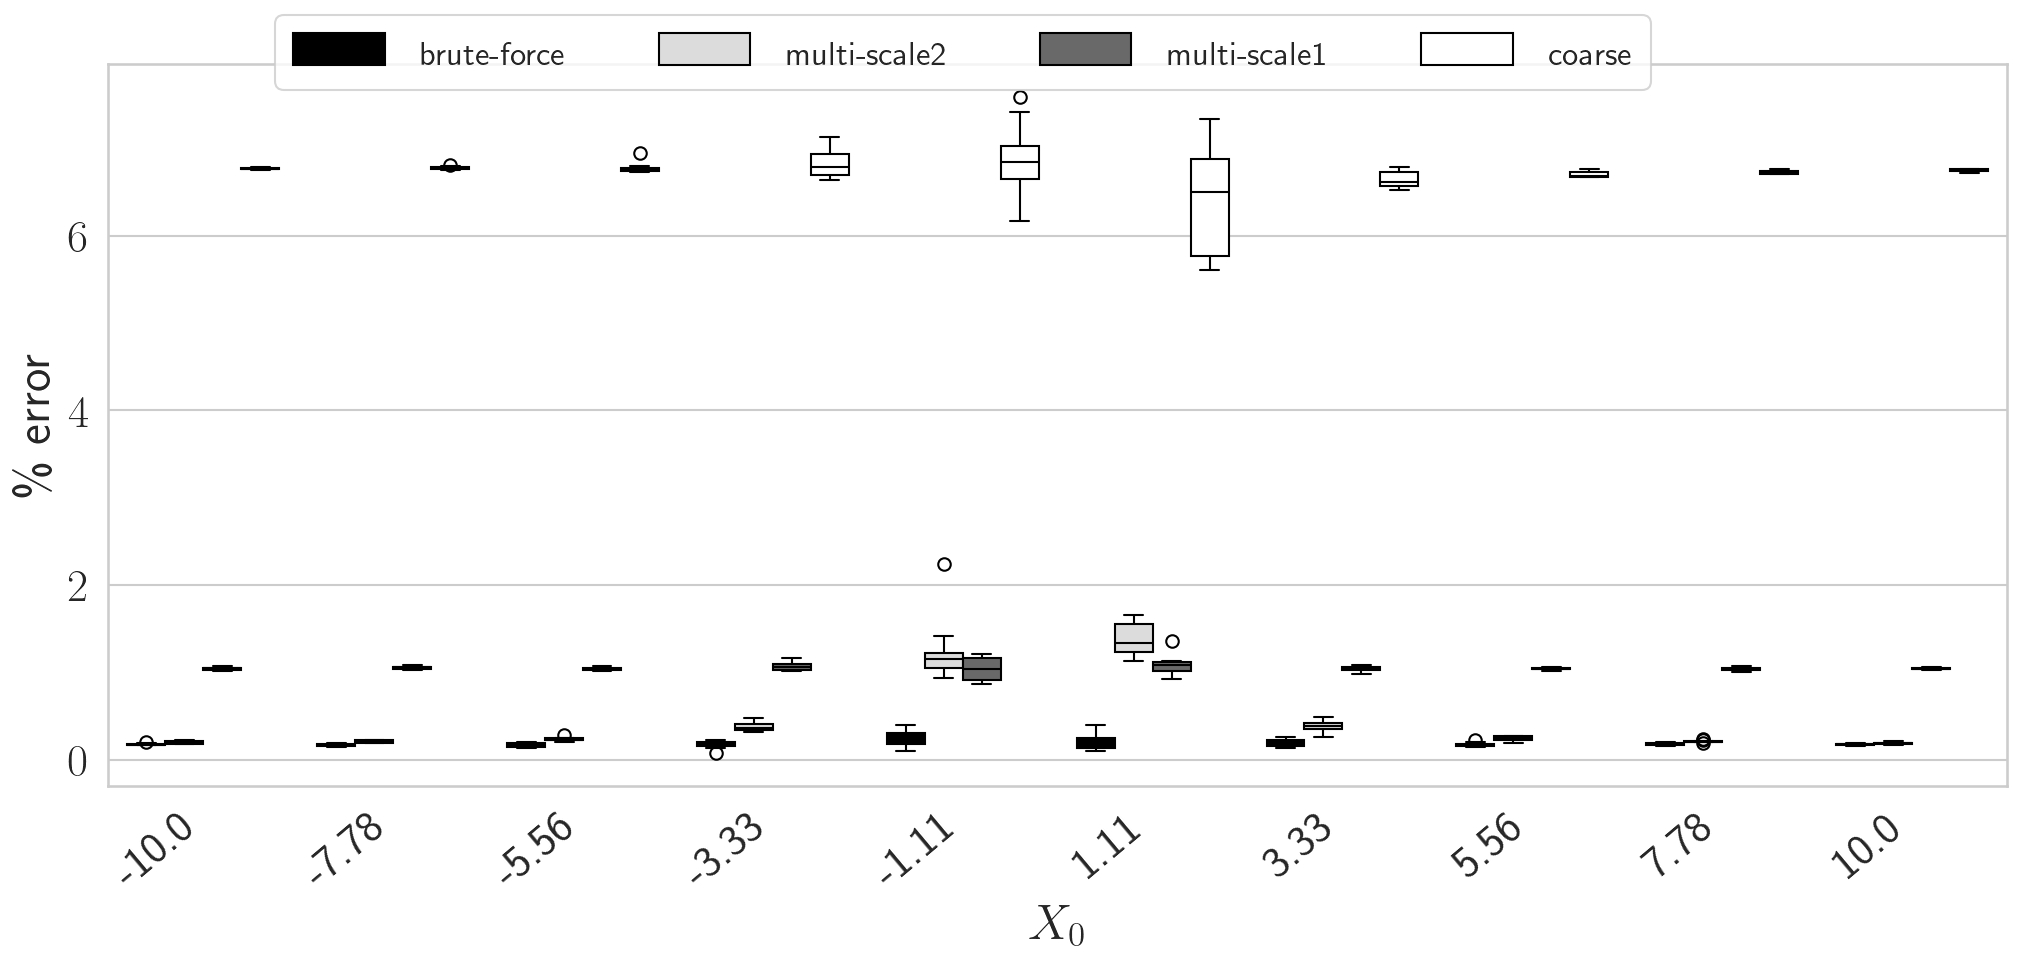

In [48]:
fig = plt.figure(figsize=(14,7),dpi=150);
sns.set_style("whitegrid");
g = sns.boxplot(data=df_box_bfmsc, y = 'rel_error', x = 'x', hue='Method', palette=['black', 'gainsboro', 'dimgrey', 'white']);#, boxprops=dict(facecolor='none'));
g.set_xticklabels([np.round(float(t.get_text()),2)  for t in g.get_xticklabels()], rotation=40, ha="right")
g.set_xlabel(r"$X_0$");
g.set_ylabel(r"\% error");
sns.move_legend(g, "upper center", bbox_to_anchor=(.45, 1.1), ncol=4, title=None)
plt.setp(g.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='12') # for legend title
plt.tight_layout();
plt.savefig("rel_{}_{}_{}_Comparison_bf_ms2_coarse{}.png".format(model_params['num_samples'],ms1_model_params['num_samples'],ms2_model_params['num_samples'],version));
plt.savefig("rel_{}_{}_{}_Comparison_bf_ms2_coarse{}.eps".format(model_params['num_samples'],ms1_model_params['num_samples'],ms2_model_params['num_samples'],version), format='eps');

In [49]:
print("rel_{}_{}_Comparison_bf_ms_coarse{}.eps".format(model_params['num_samples'],ms1_model_params['num_samples'],version))

rel_100_50_Comparison_bf_ms_coarse_7.eps
